# Imports

In [1]:
pip install monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.6 MB/s eta 0:00:00


In [2]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

# Visualizing Results

In [3]:
in_dir = "/content/drive/MyDrive/dataset"
model_dir = "/content/drive/MyDrive/liver_segmentation"

In [4]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))

test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

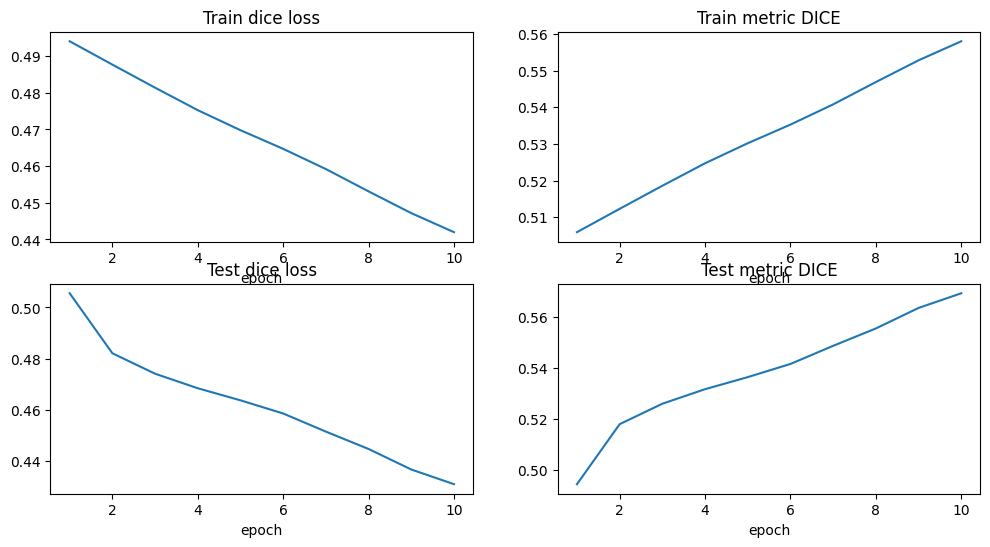

In [5]:
plt.figure("Results: ", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

# Preparing train-test files

In [6]:
# volumes - holds the file paths to the train/test volume images
# segmentation -  holds the file paths to the corresponding segmentation masks for training/testing

path_train_volumes = sorted(glob(os.path.join(in_dir, "train_image", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "train_label", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "test_image", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "test_label", "*.nii.gz")))


In [7]:
path_train_volumes

['/content/drive/MyDrive/dataset/train_image/liver_0_0.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_1_0.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_2_5.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_2_6.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_2_7.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_3_4.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_3_5.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_3_6.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_3_7.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_4_5.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_4_6.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_4_7.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_4_8.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_4_9.nii.gz',
 '/content/drive/MyDrive/dataset/train_image/liver_5_4.nii.gz',
 '/content/drive/MyDrive/dataset/train_i

In [8]:
path_test_volumes

['/content/drive/MyDrive/dataset/test_image/liver_9_5.nii.gz',
 '/content/drive/MyDrive/dataset/test_image/liver_9_6.nii.gz',
 '/content/drive/MyDrive/dataset/test_image/liver_9_7.nii.gz']

In [9]:
# Create lists of dictionaries to pair each training and testing volume image with its corresponding segmentation mask
train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]

In [10]:
train_files

[{'image': '/content/drive/MyDrive/dataset/train_image/liver_0_0.nii.gz',
  'label': '/content/drive/MyDrive/dataset/train_label/liver_0_0.nii.gz'},
 {'image': '/content/drive/MyDrive/dataset/train_image/liver_1_0.nii.gz',
  'label': '/content/drive/MyDrive/dataset/train_label/liver_1_0.nii.gz'},
 {'image': '/content/drive/MyDrive/dataset/train_image/liver_2_5.nii.gz',
  'label': '/content/drive/MyDrive/dataset/train_label/liver_2_5.nii.gz'},
 {'image': '/content/drive/MyDrive/dataset/train_image/liver_2_6.nii.gz',
  'label': '/content/drive/MyDrive/dataset/train_label/liver_2_6.nii.gz'},
 {'image': '/content/drive/MyDrive/dataset/train_image/liver_2_7.nii.gz',
  'label': '/content/drive/MyDrive/dataset/train_label/liver_2_7.nii.gz'},
 {'image': '/content/drive/MyDrive/dataset/train_image/liver_3_4.nii.gz',
  'label': '/content/drive/MyDrive/dataset/train_label/liver_3_4.nii.gz'},
 {'image': '/content/drive/MyDrive/dataset/train_image/liver_3_5.nii.gz',
  'label': '/content/drive/MyDri

In [11]:
test_files

[{'image': '/content/drive/MyDrive/dataset/test_image/liver_9_5.nii.gz',
  'label': '/content/drive/MyDrive/dataset/test_label/liver_9_5.nii.gz'},
 {'image': '/content/drive/MyDrive/dataset/test_image/liver_9_6.nii.gz',
  'label': '/content/drive/MyDrive/dataset/test_label/liver_9_6.nii.gz'},
 {'image': '/content/drive/MyDrive/dataset/test_image/liver_9_7.nii.gz',
  'label': '/content/drive/MyDrive/dataset/test_label/liver_9_7.nii.gz'}]

# Test - Transforms, Dataset & DataLoader

In [12]:
# Preprocessing - as training
test_transforms = Compose(
    [
        LoadImaged(keys=['image', 'label']),
        AddChanneld(keys=['image', 'label']),
        Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2)),
        ScaleIntensityRanged(keys='image', a_min=-200, a_max=200, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['image', 'label'], source_key='image'),
        Resized(keys=['image', 'label'], spatial_size=[128,128,128]),
        ToTensord(keys=['image', 'label'])
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if ima

In [13]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [14]:
test_ds[0]

{'image': metatensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
          

In [15]:
loader = iter(test_loader)
next(loader)

{'image': metatensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]],
 
           ...,
 
           [[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ...

# Testing

In [16]:
# Load the model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(
    spatial_dims=3, # Indicates a 3D U-Net model
    in_channels=1,  # Indicates a 3D U-Net model
    out_channels=2, # Number of output channels (e.g., for segmentation tasks)
    channels=(16, 32, 64, 128, 256),  # Number of channels at each U-Net layer
    strides=(2, 2, 2, 2), # Spatial down-sampling strides
    num_res_units=2, # Number of residual units
    norm=Norm.BATCH).to(device) # Type of normalization (e.g., batch normalization)


In [17]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


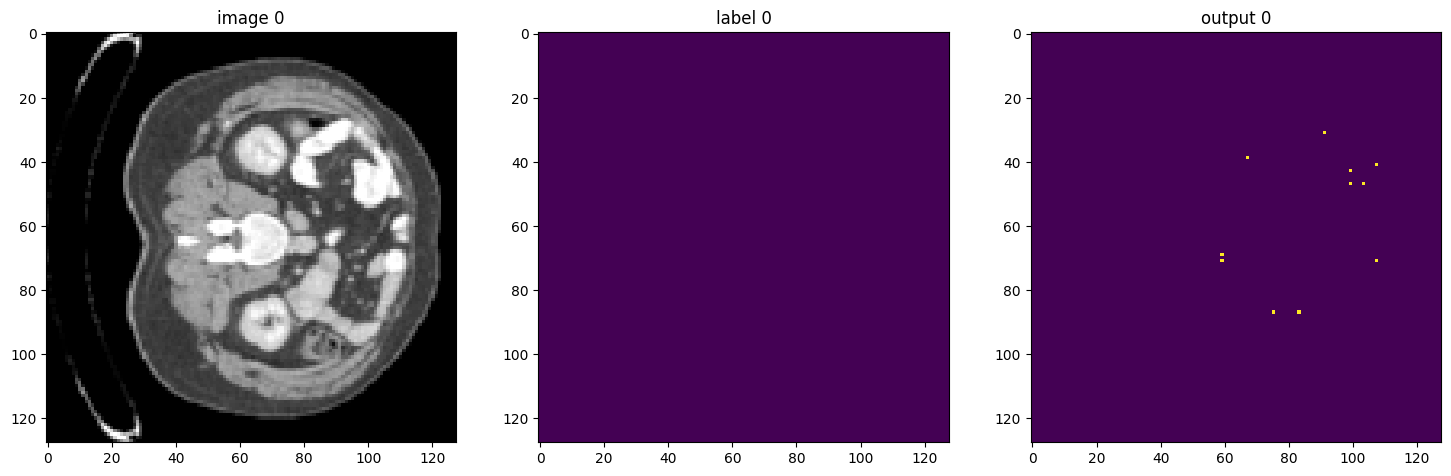

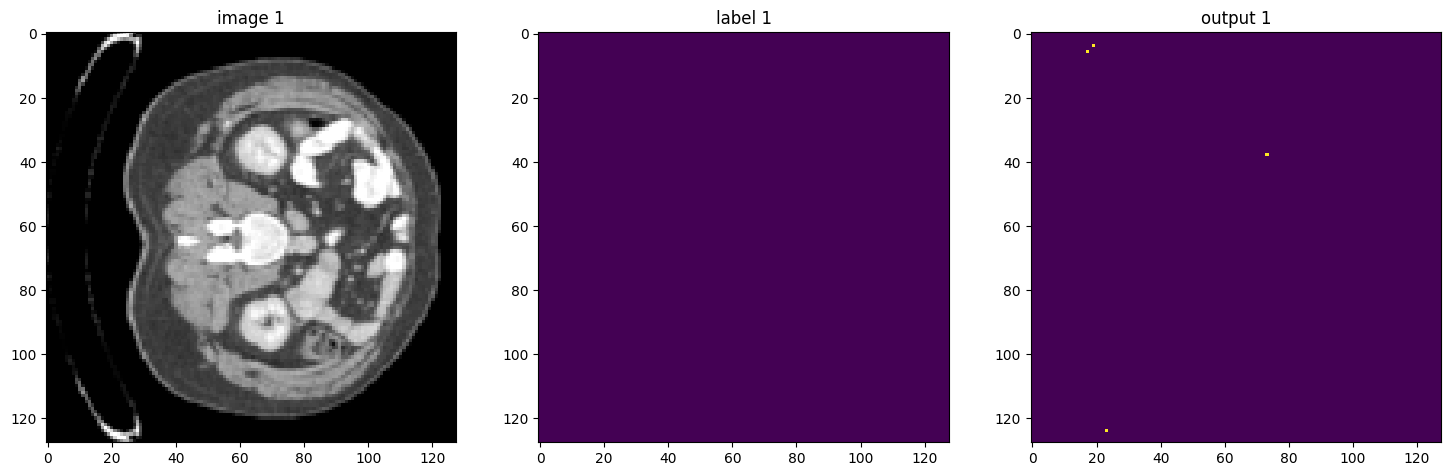

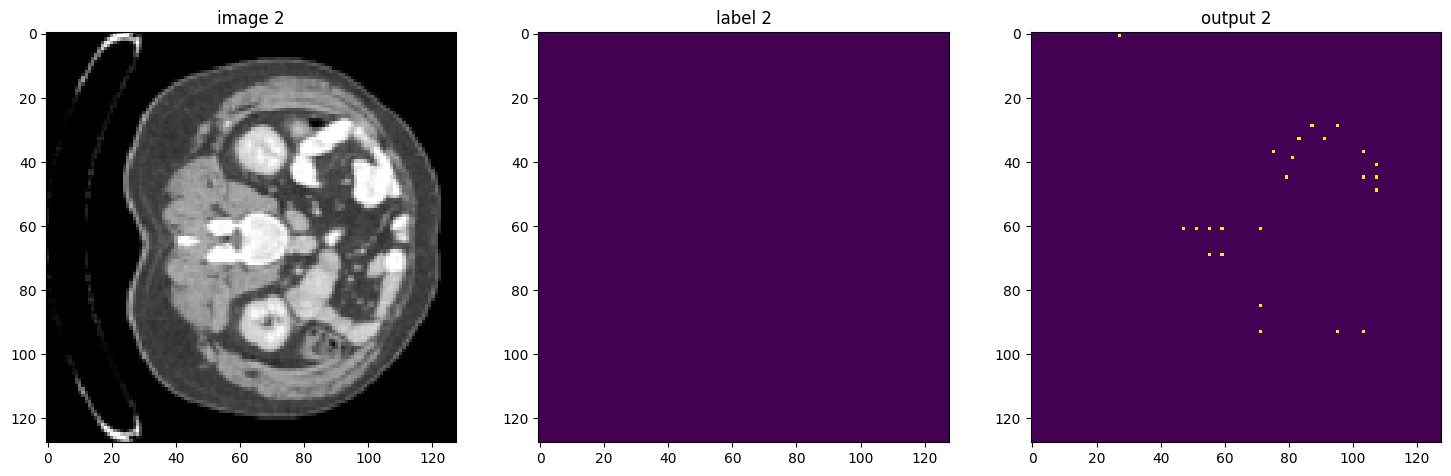

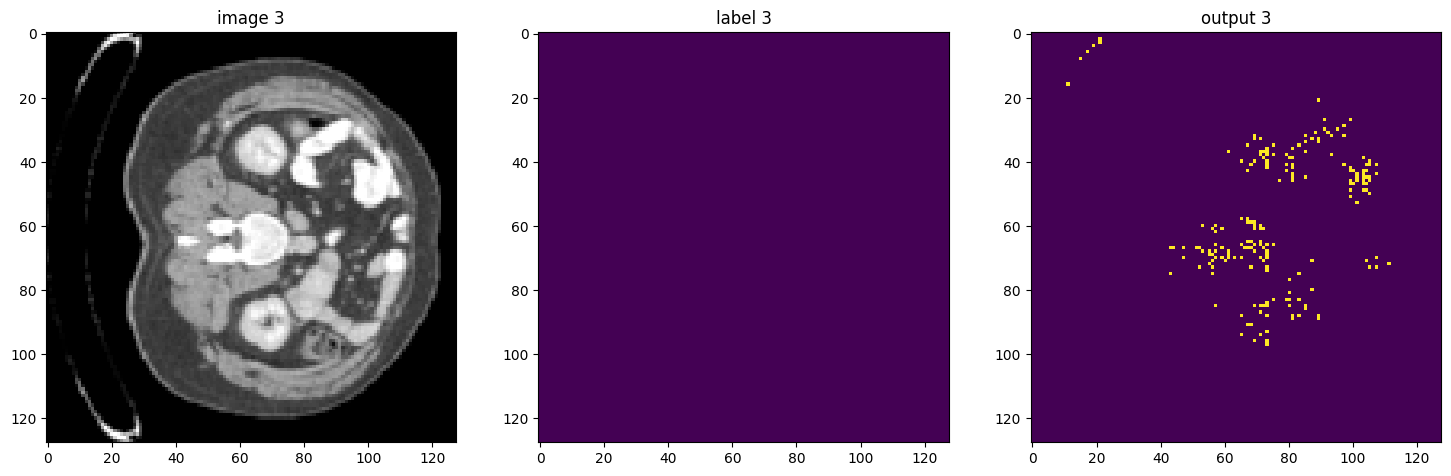

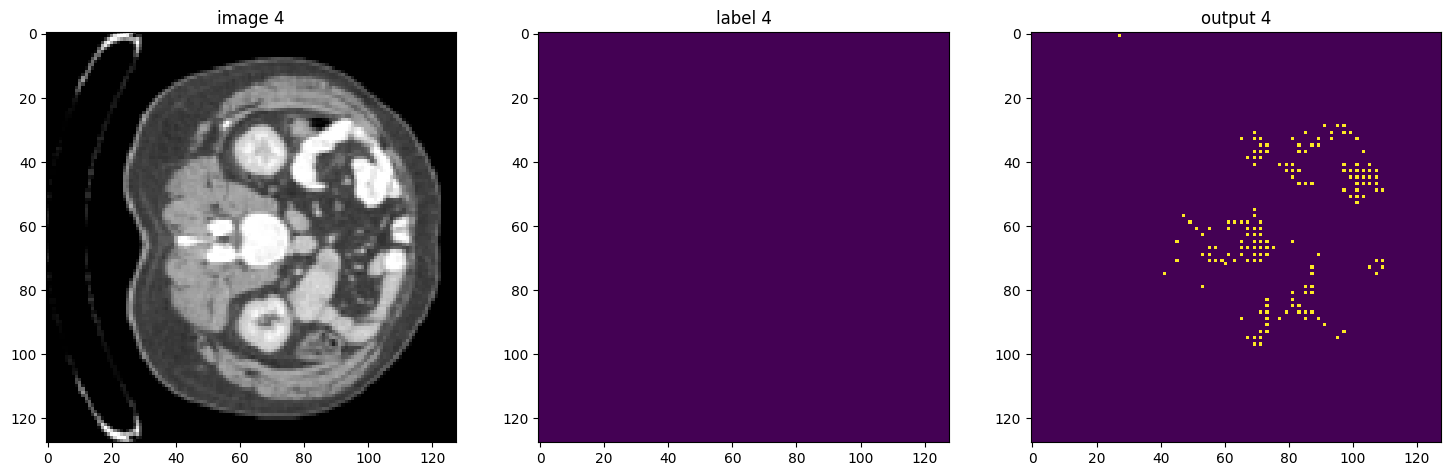

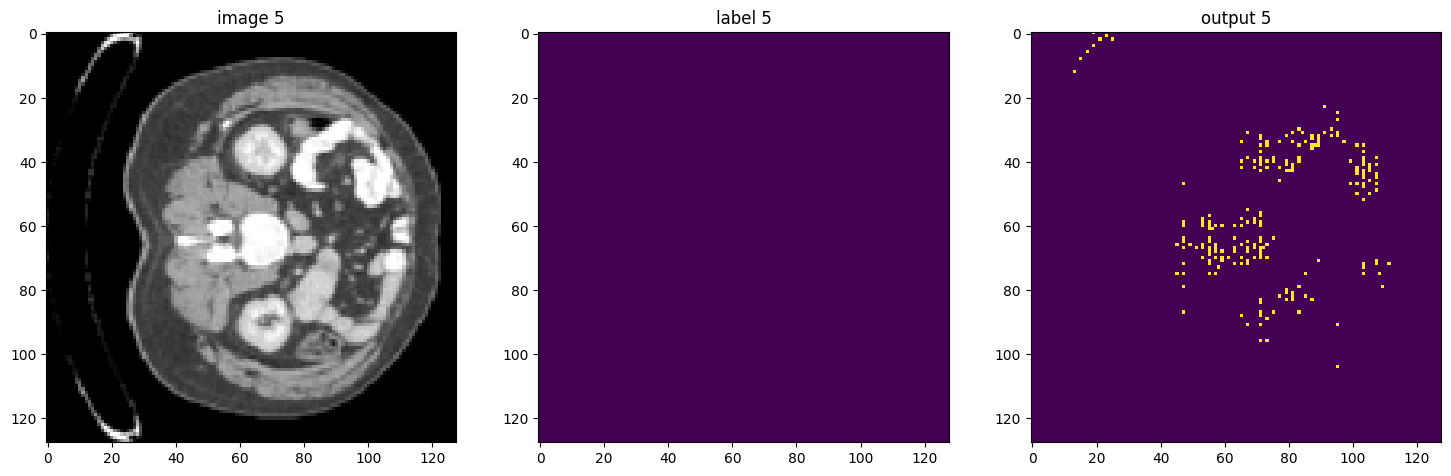

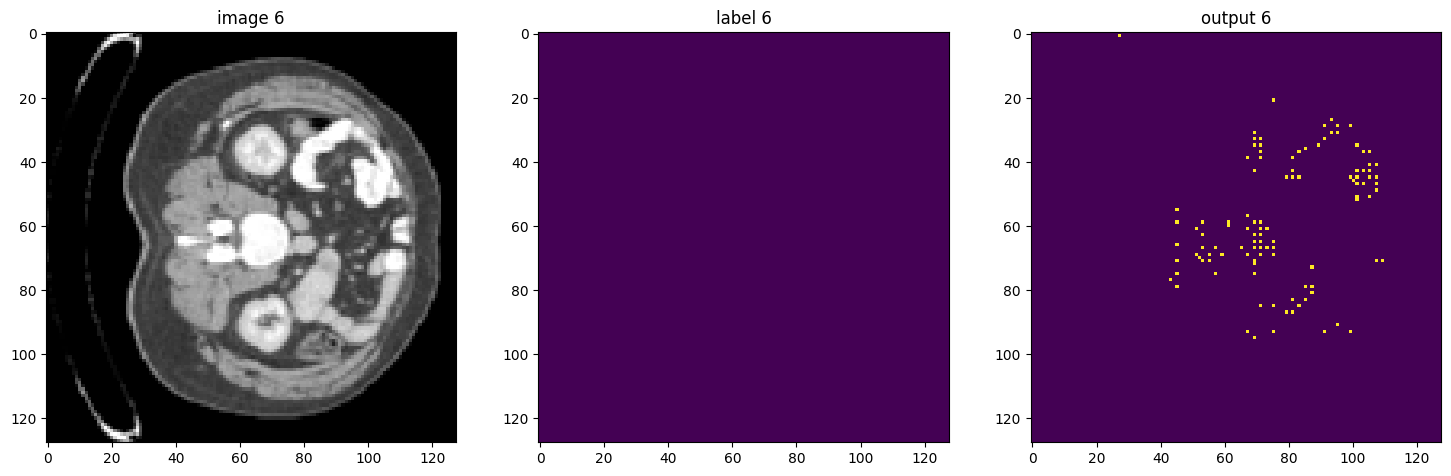

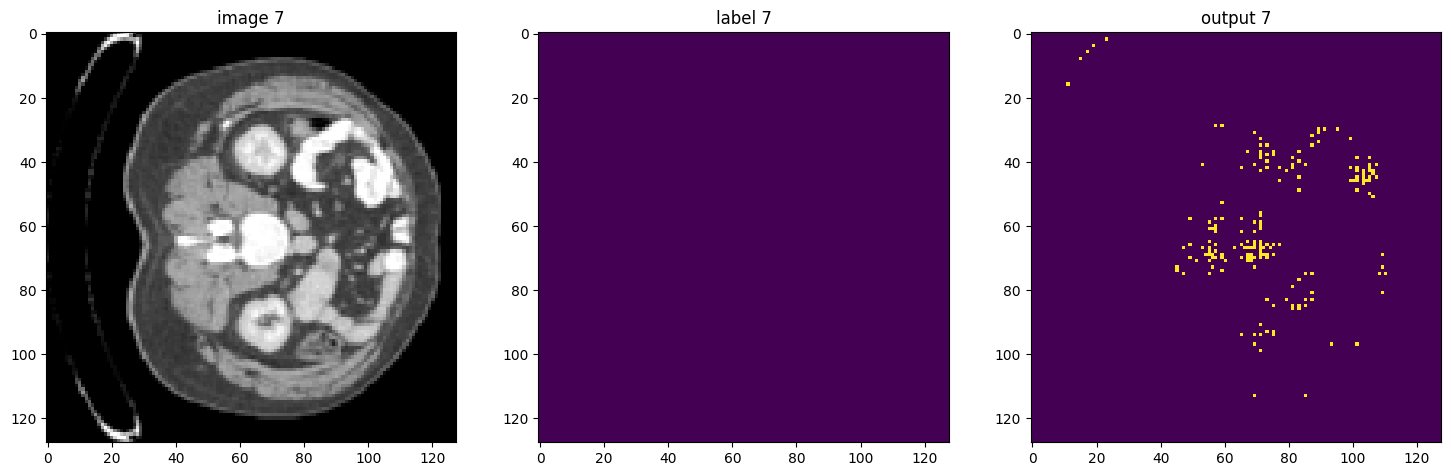

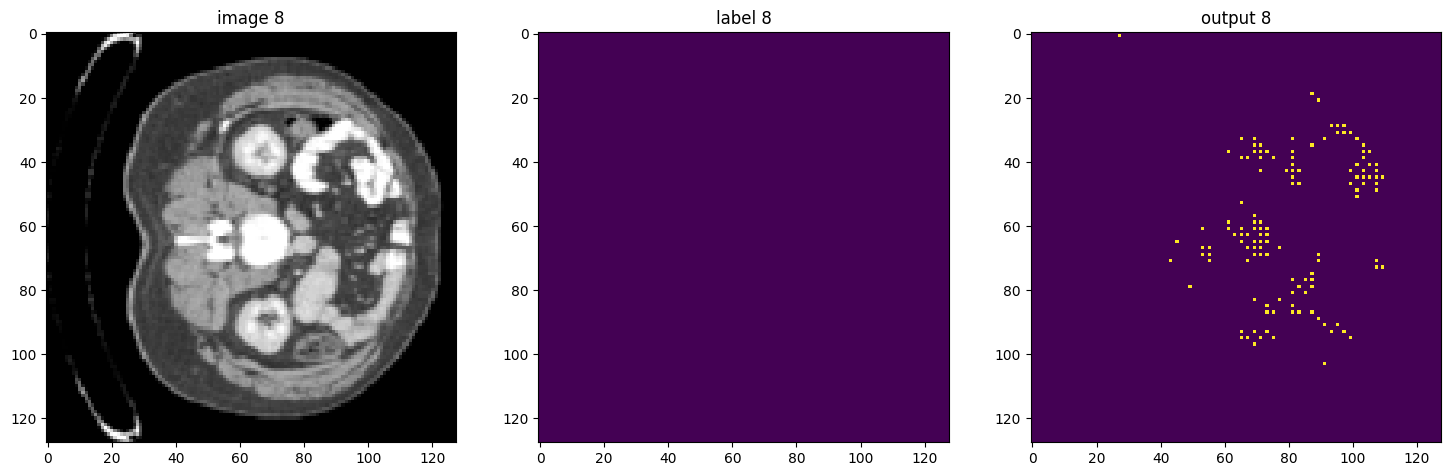

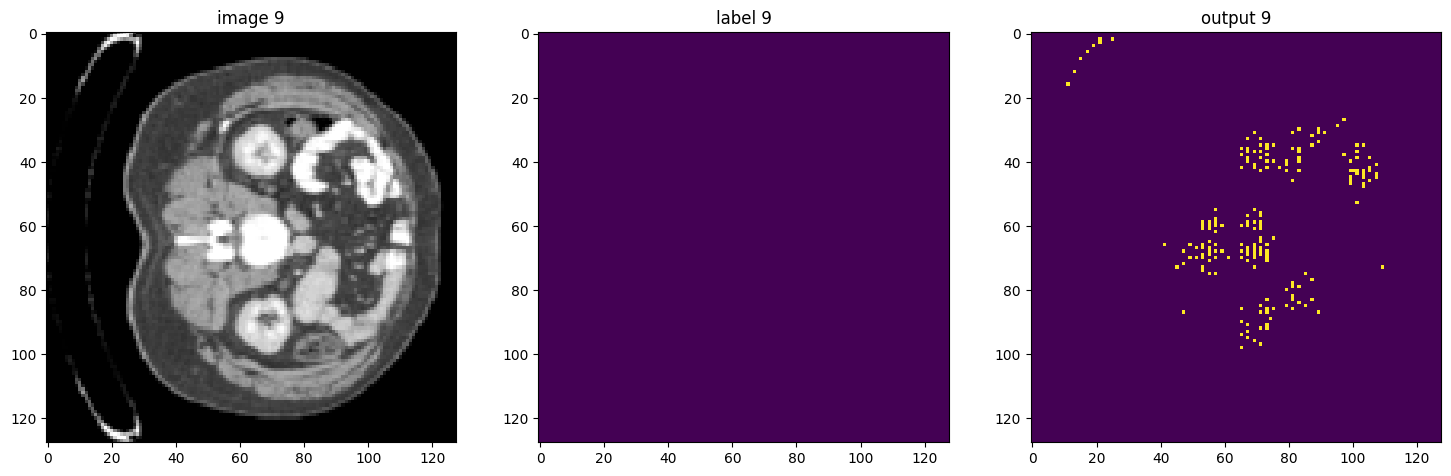

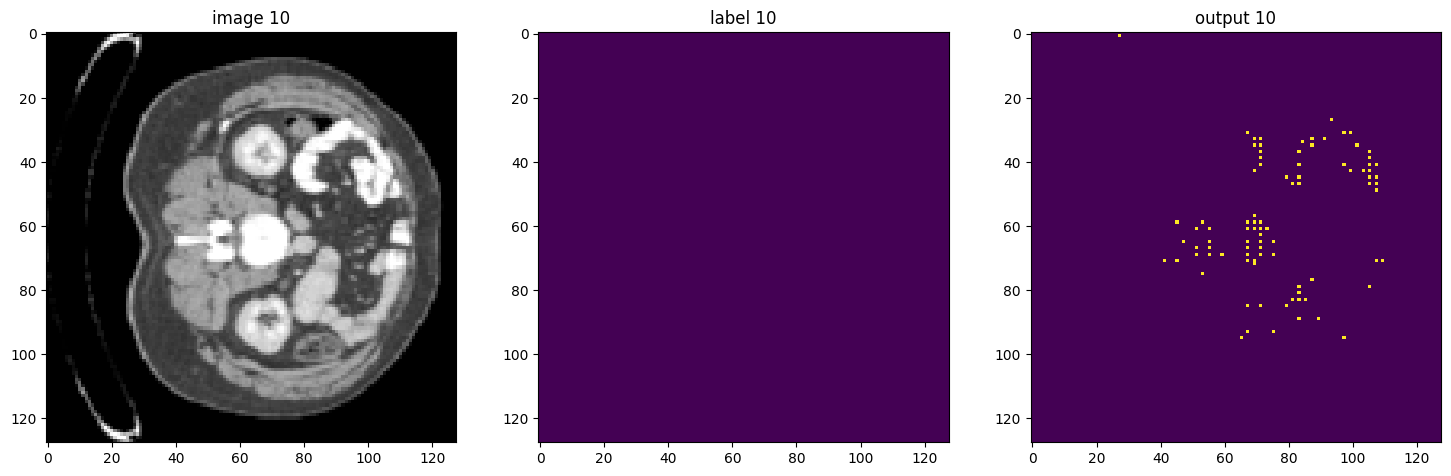

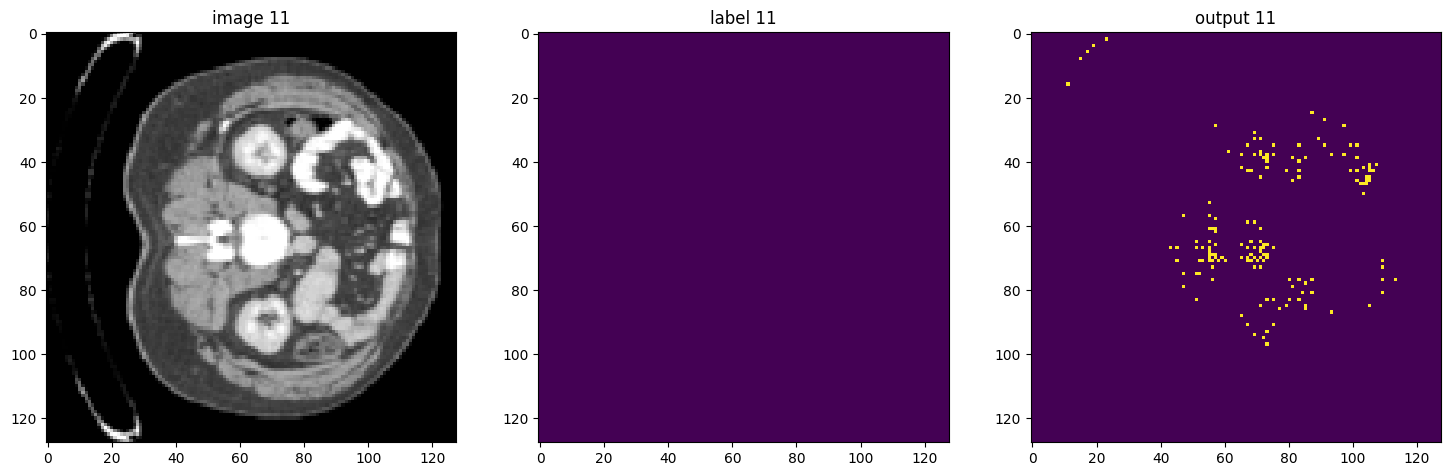

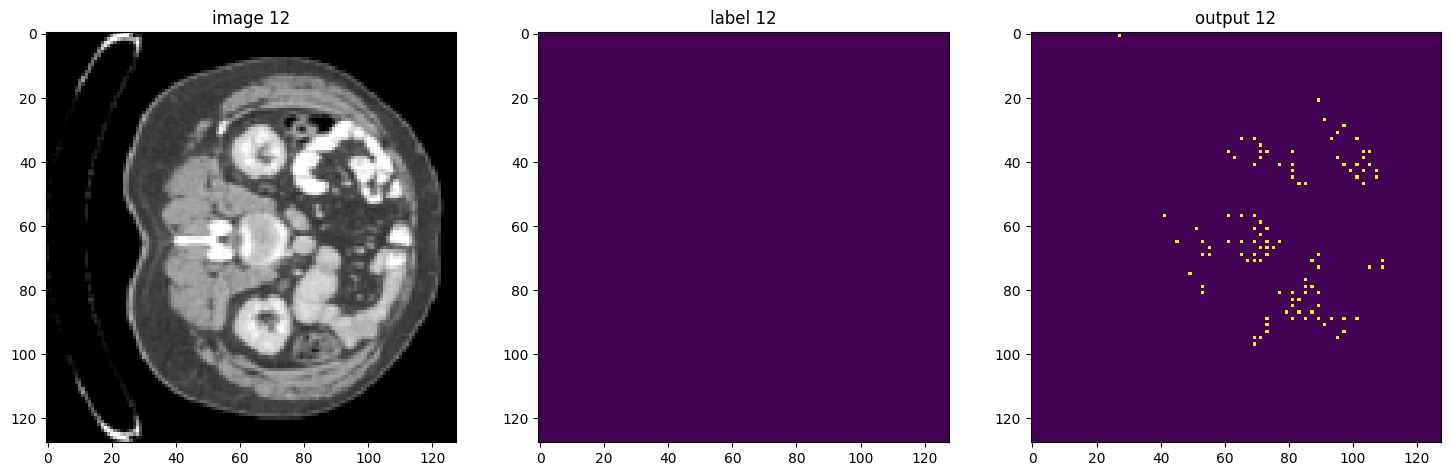

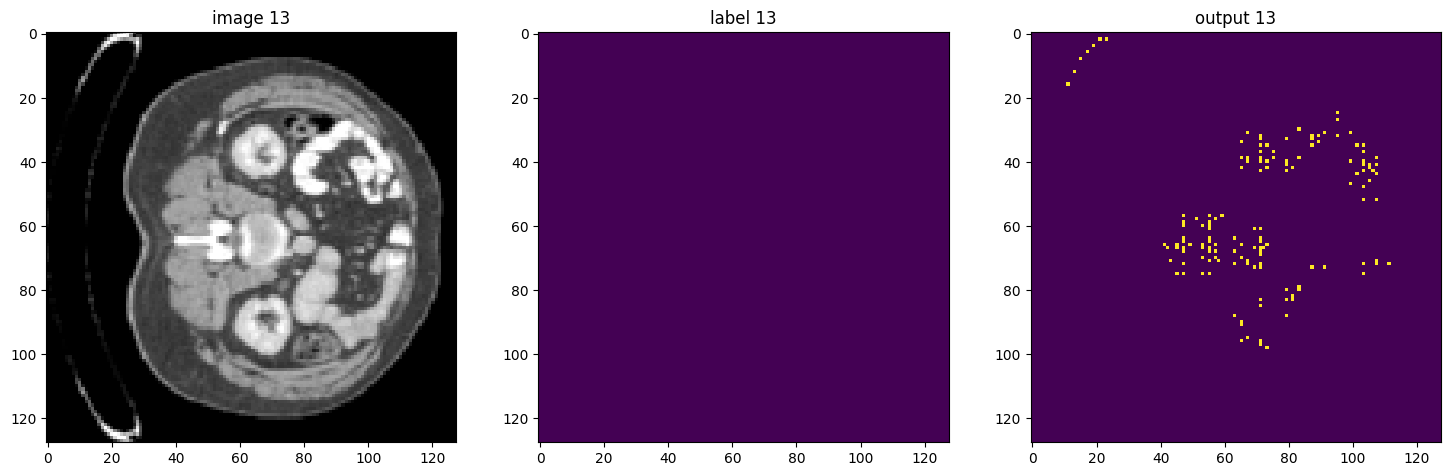

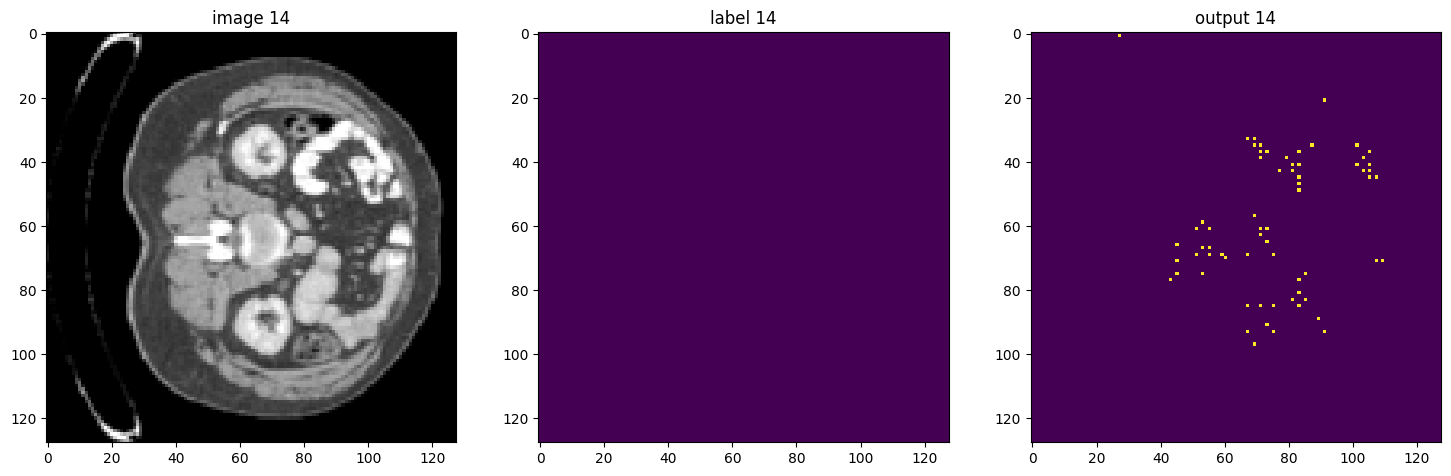

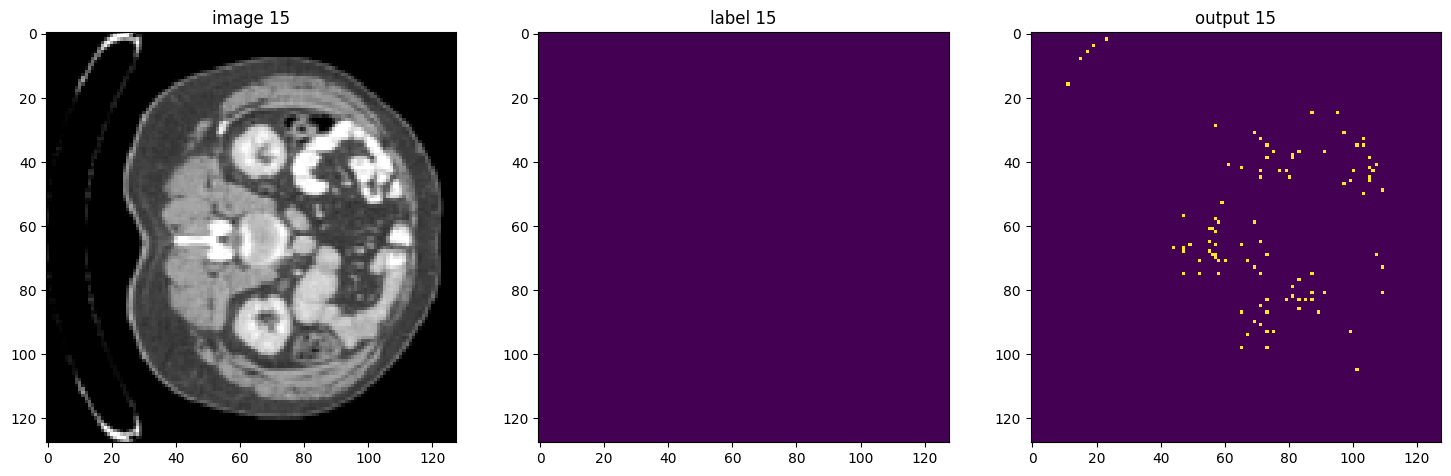

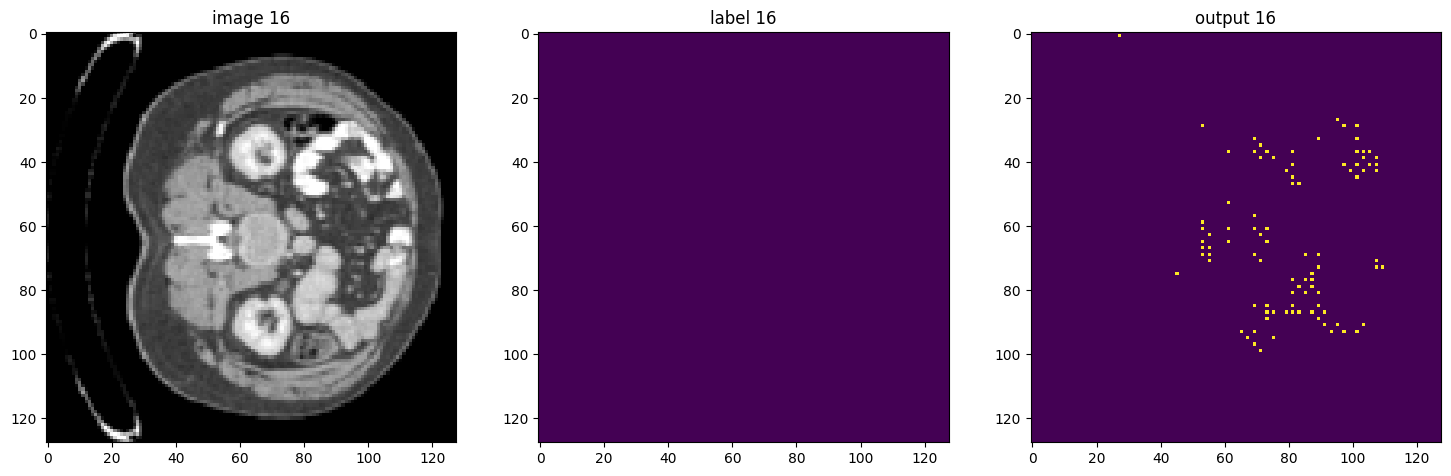

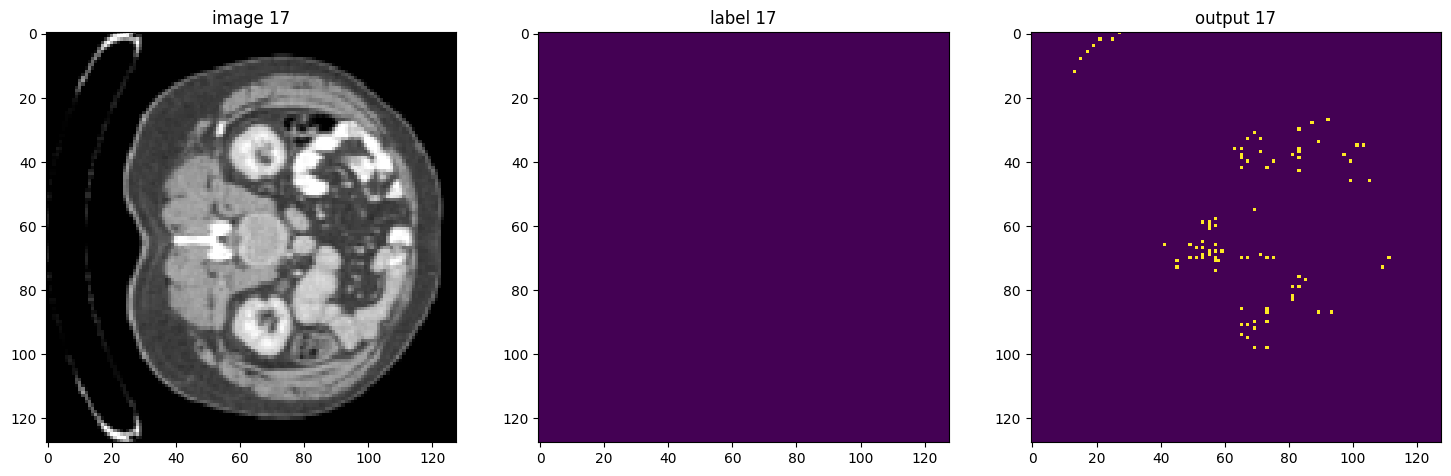

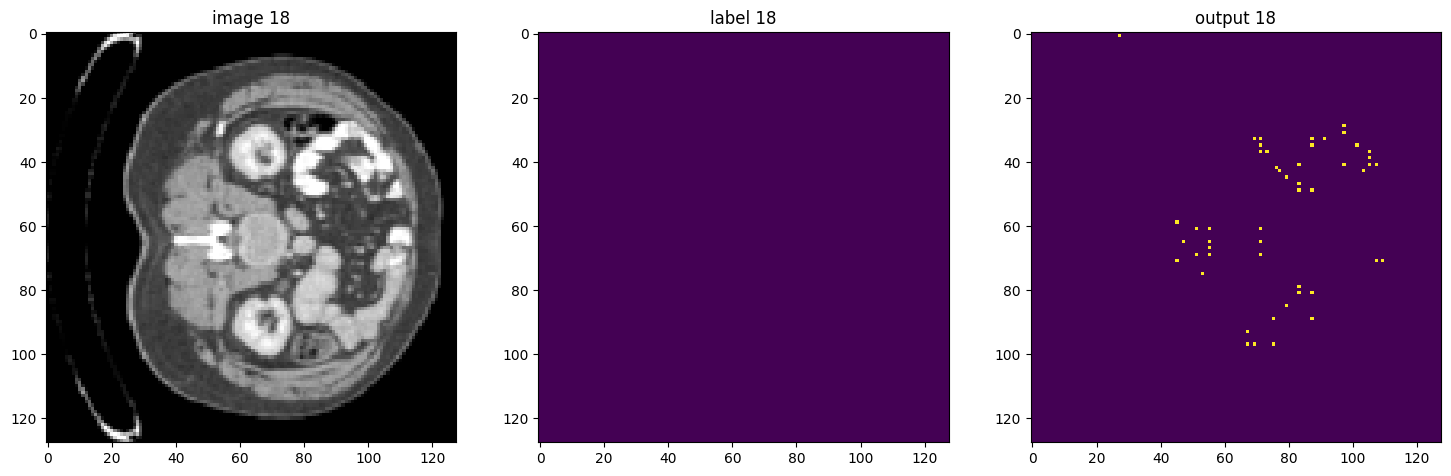

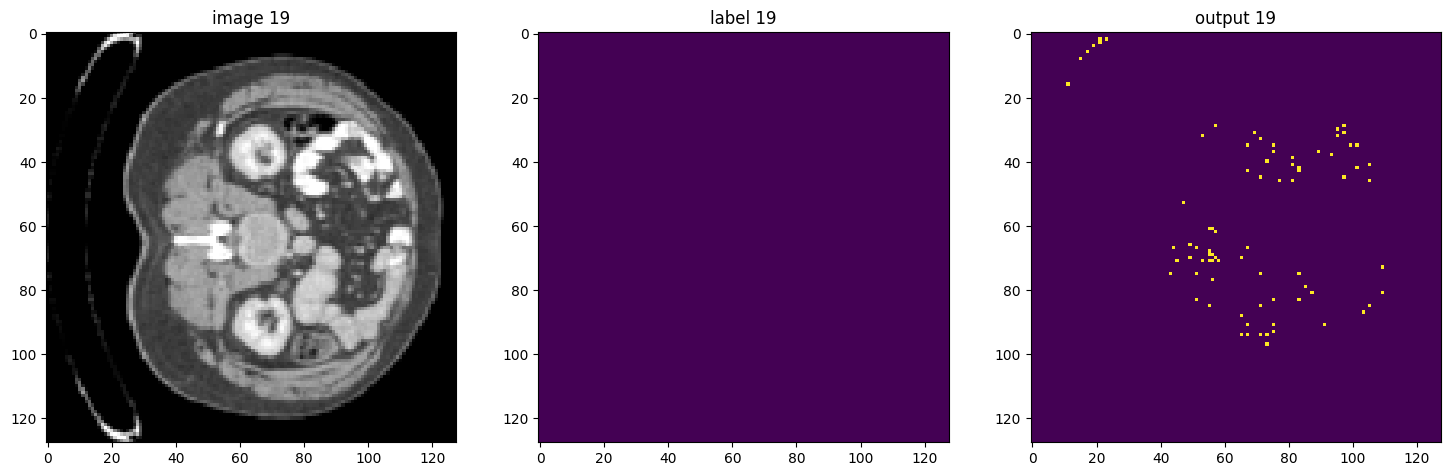

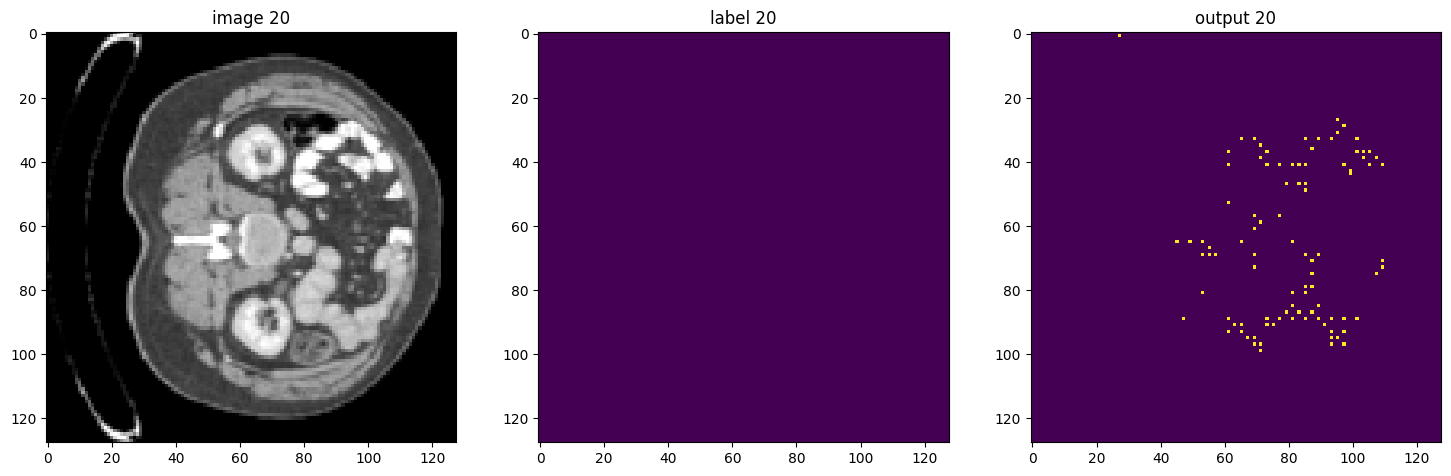

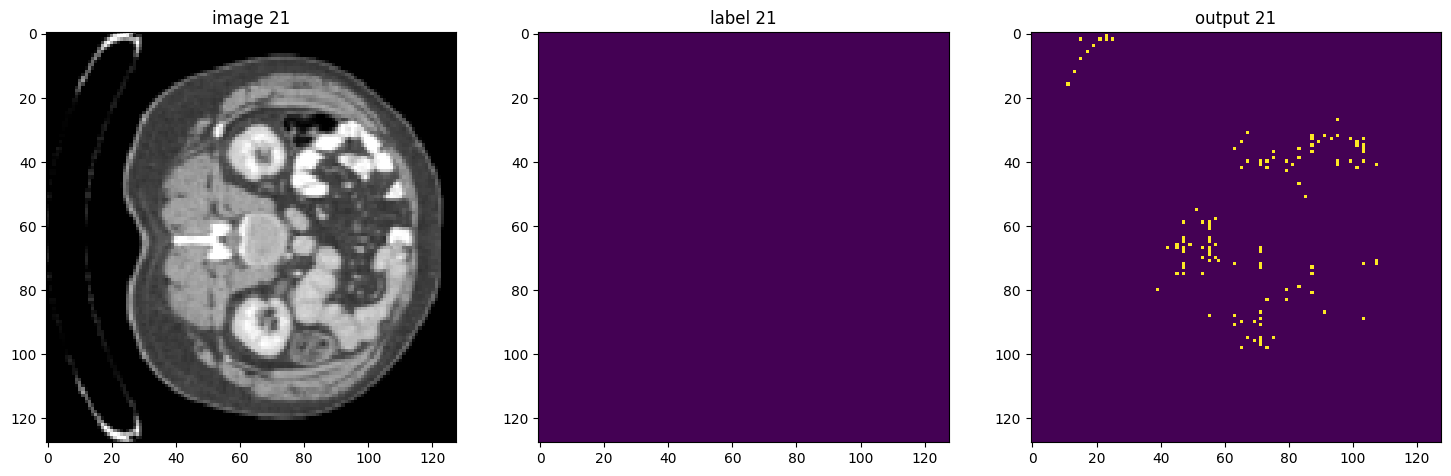

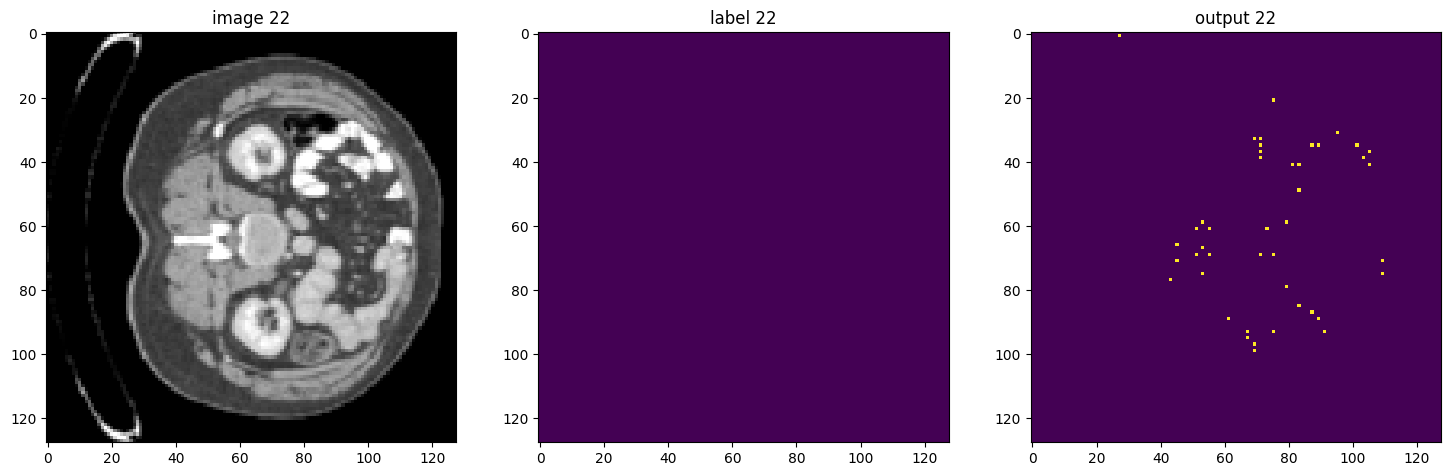

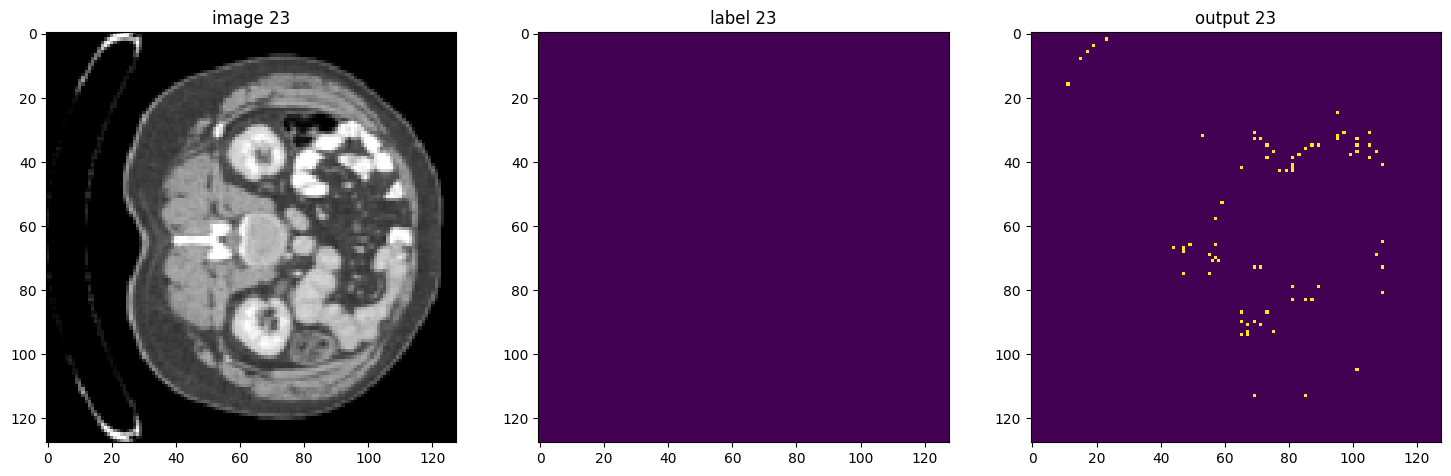

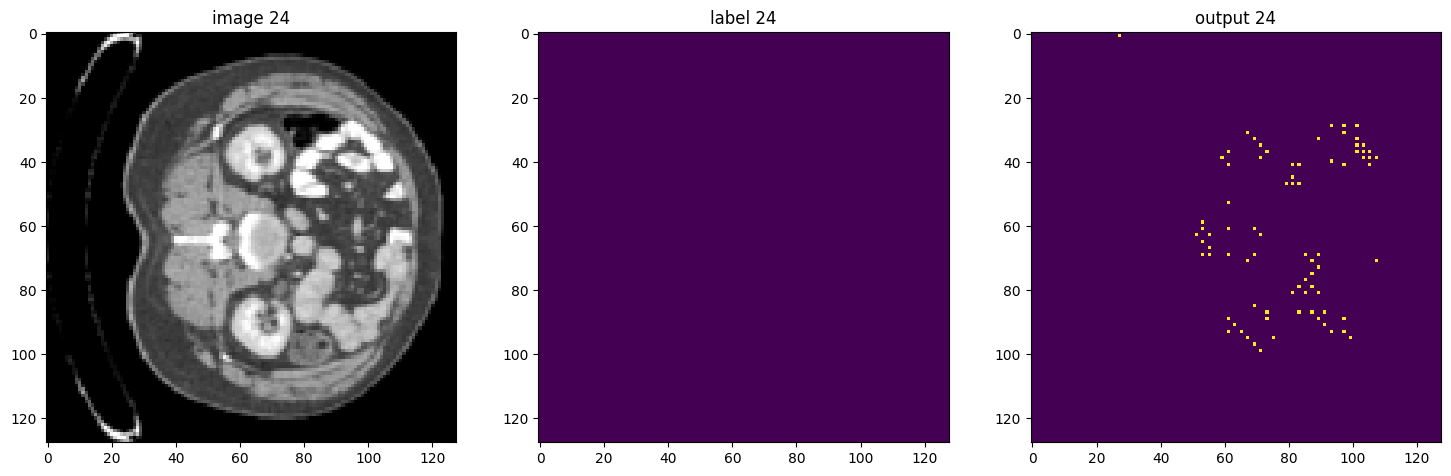

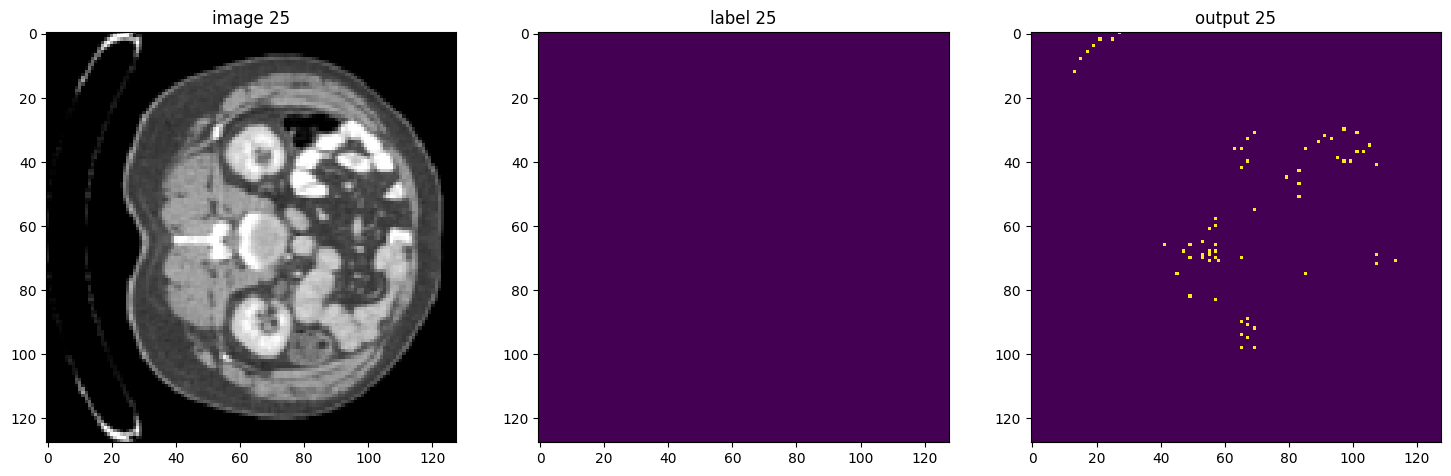

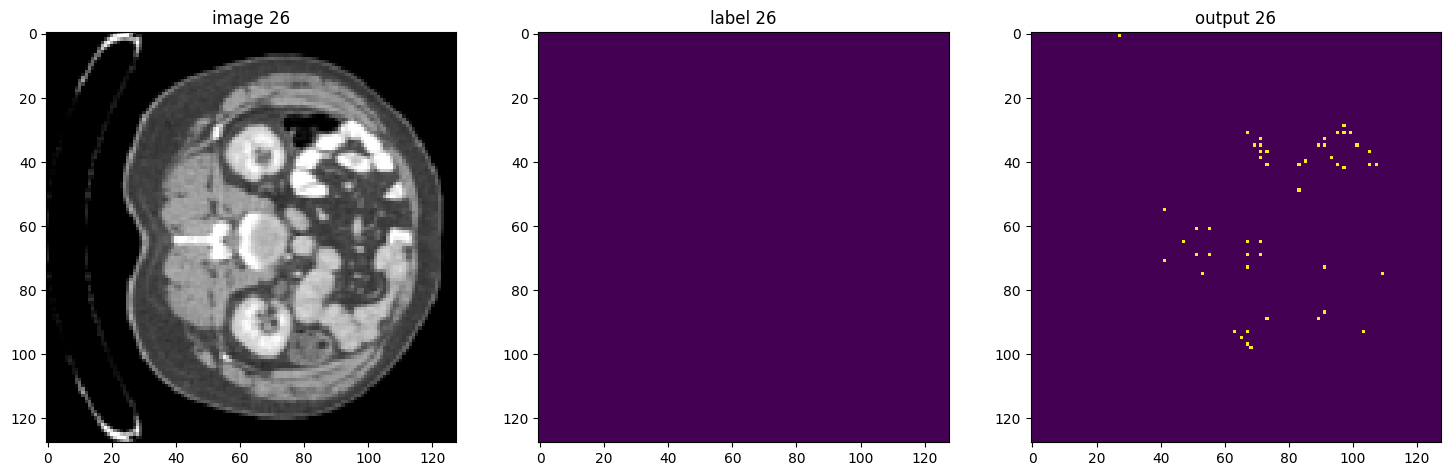

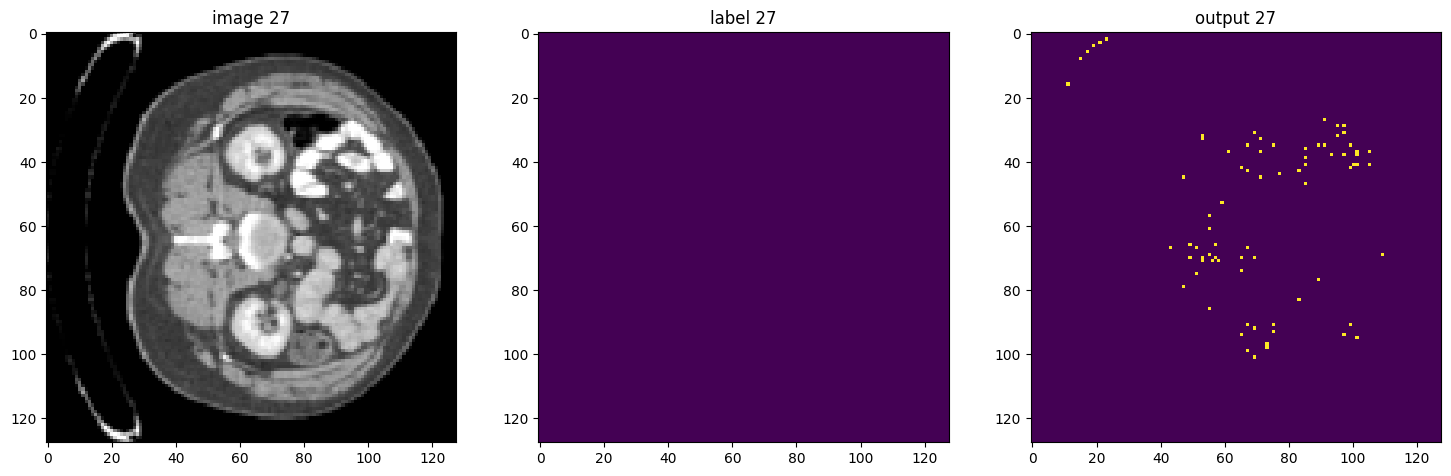

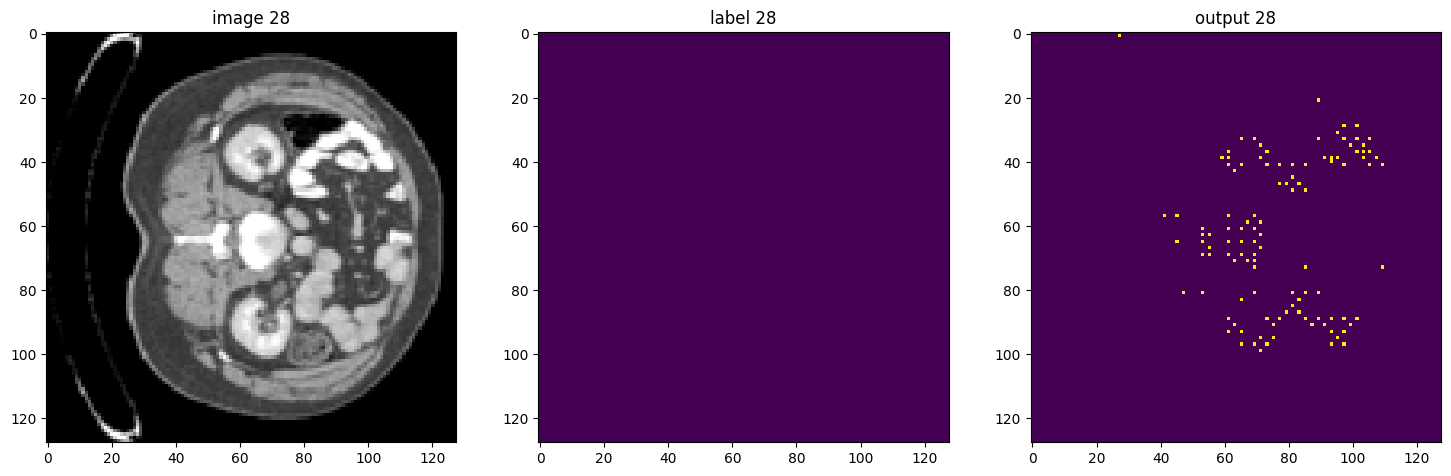

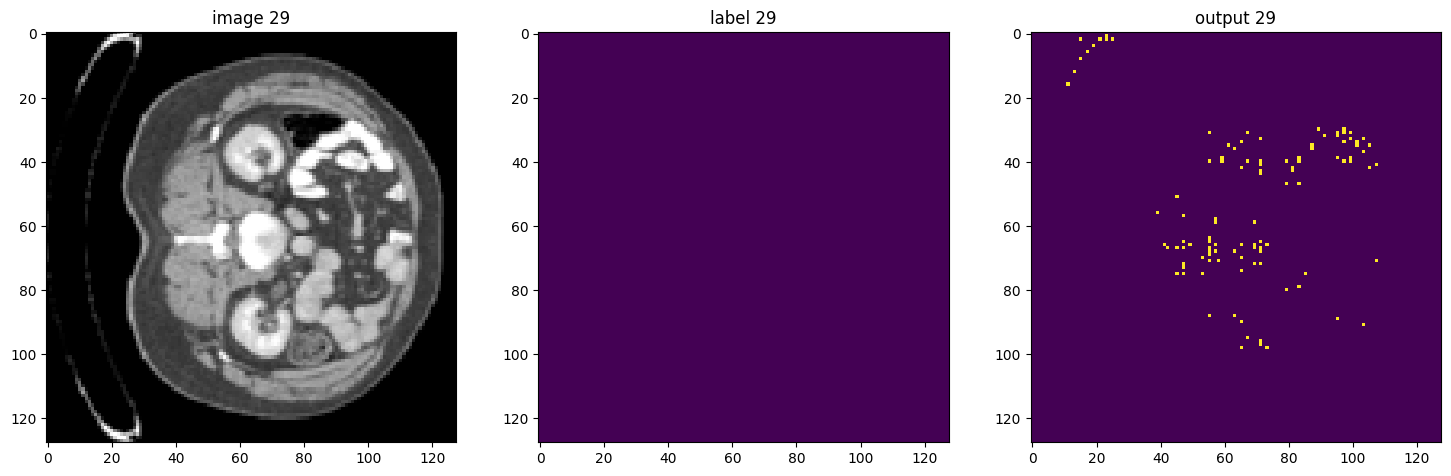

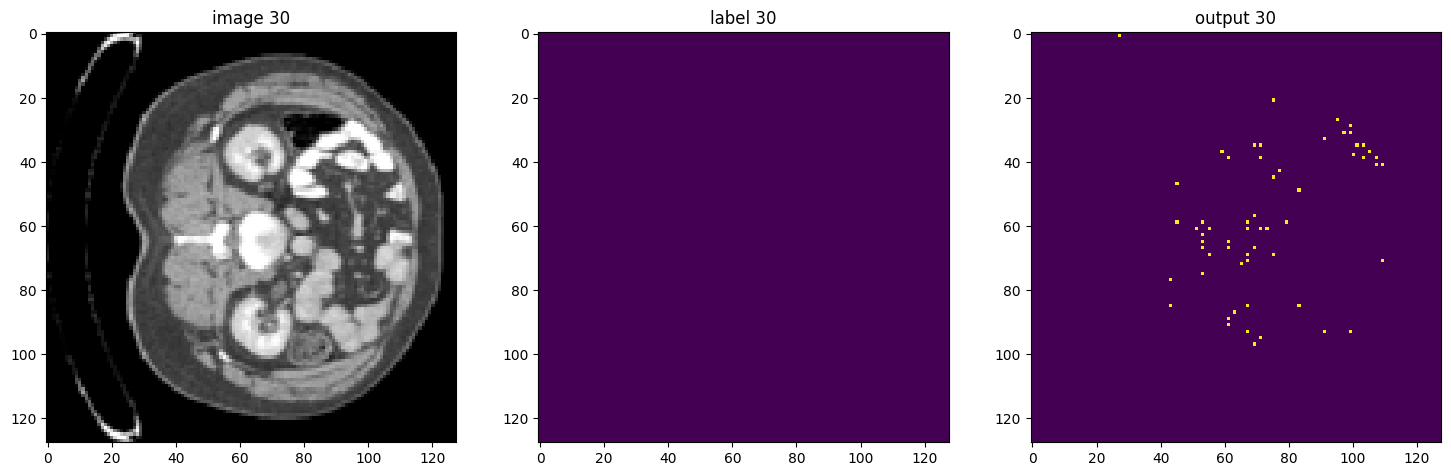

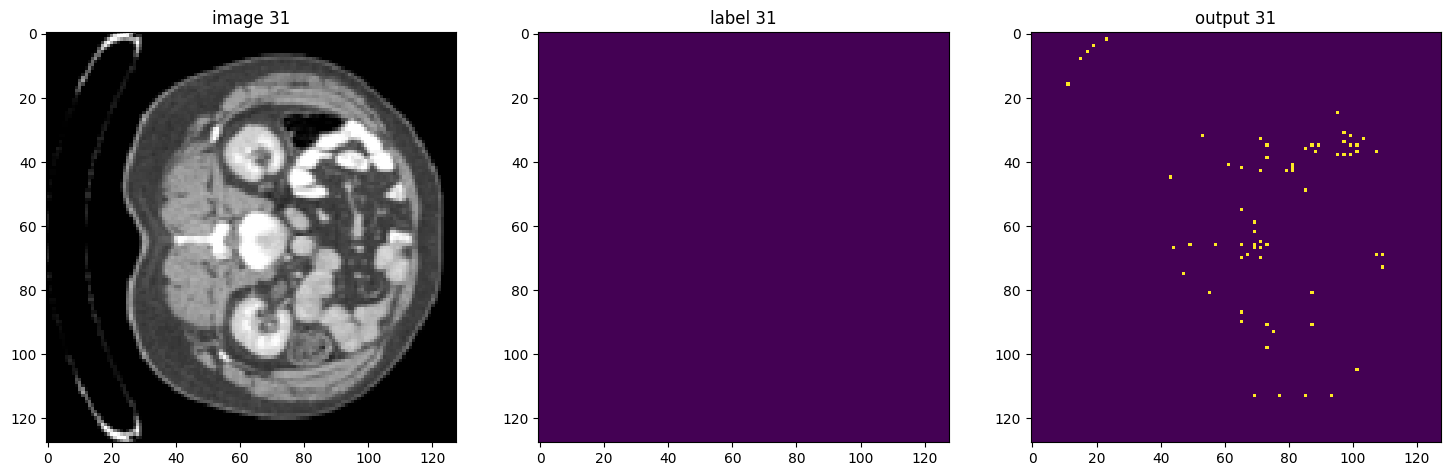

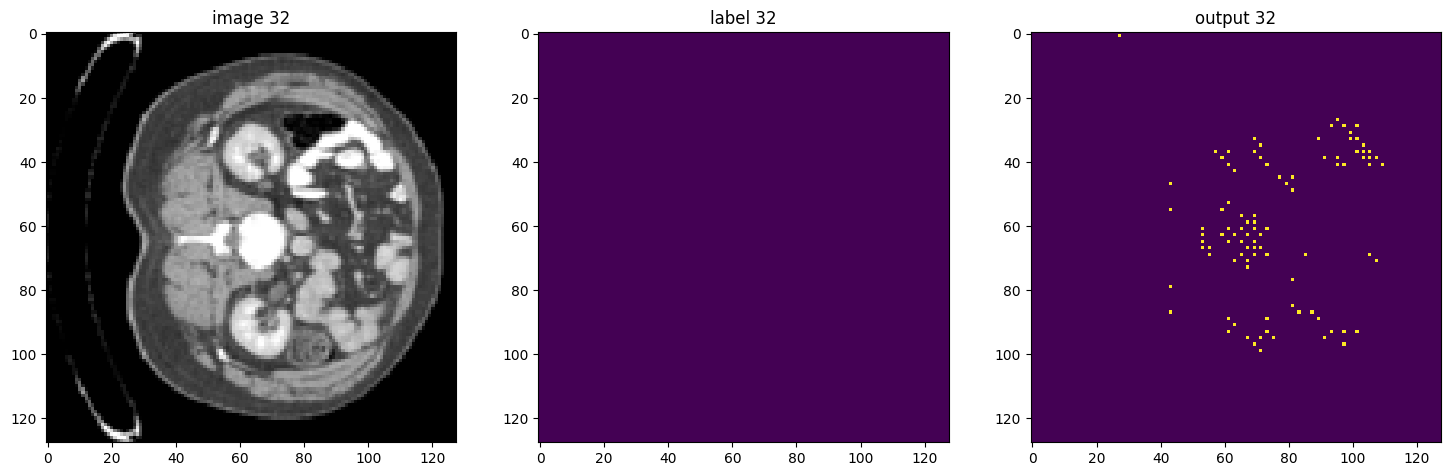

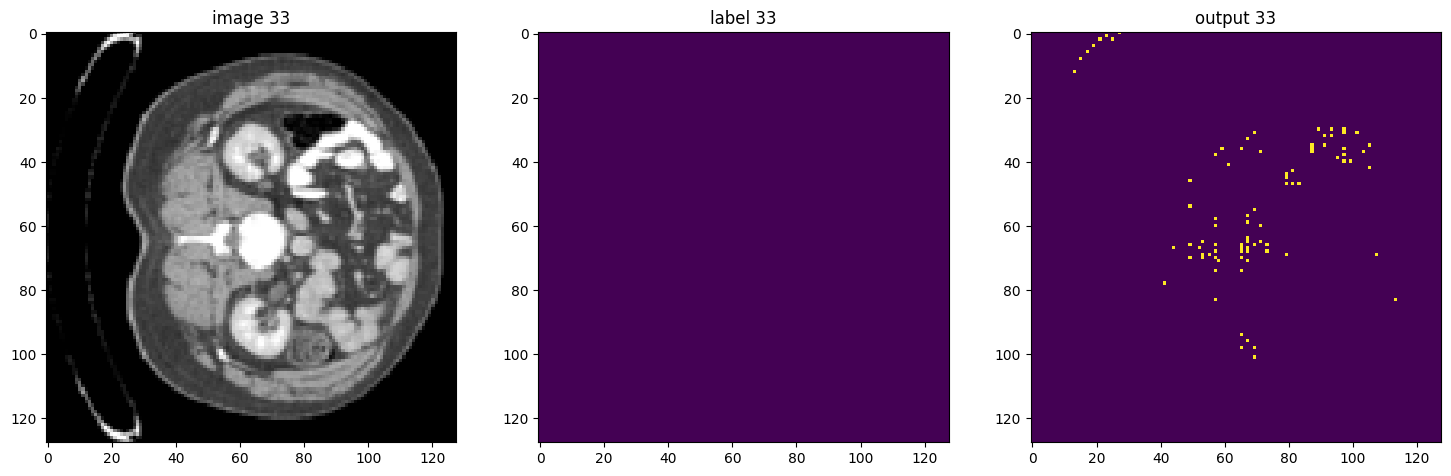

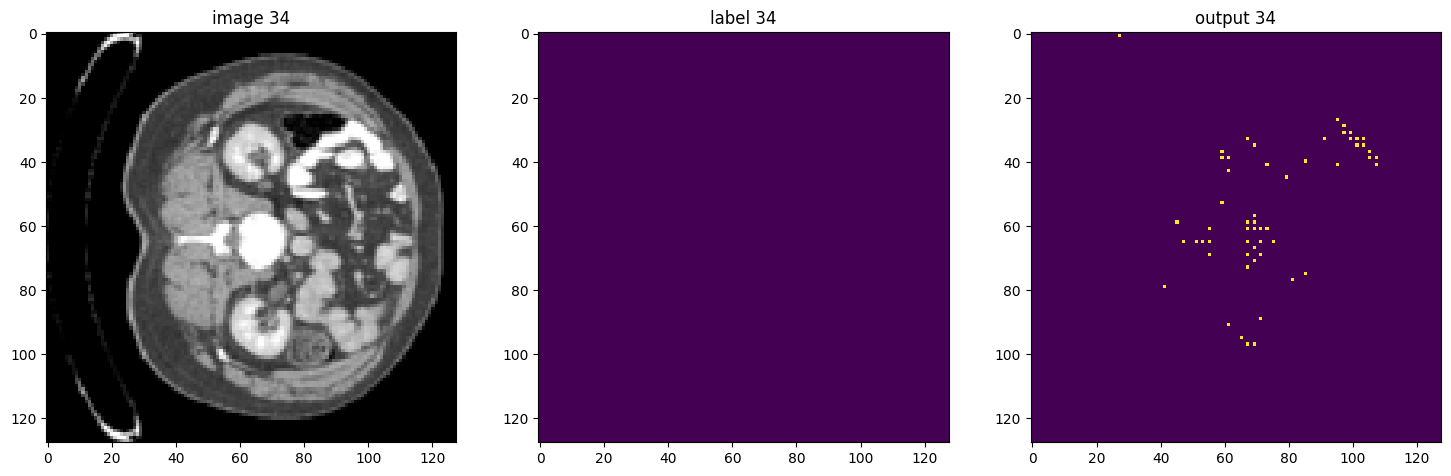

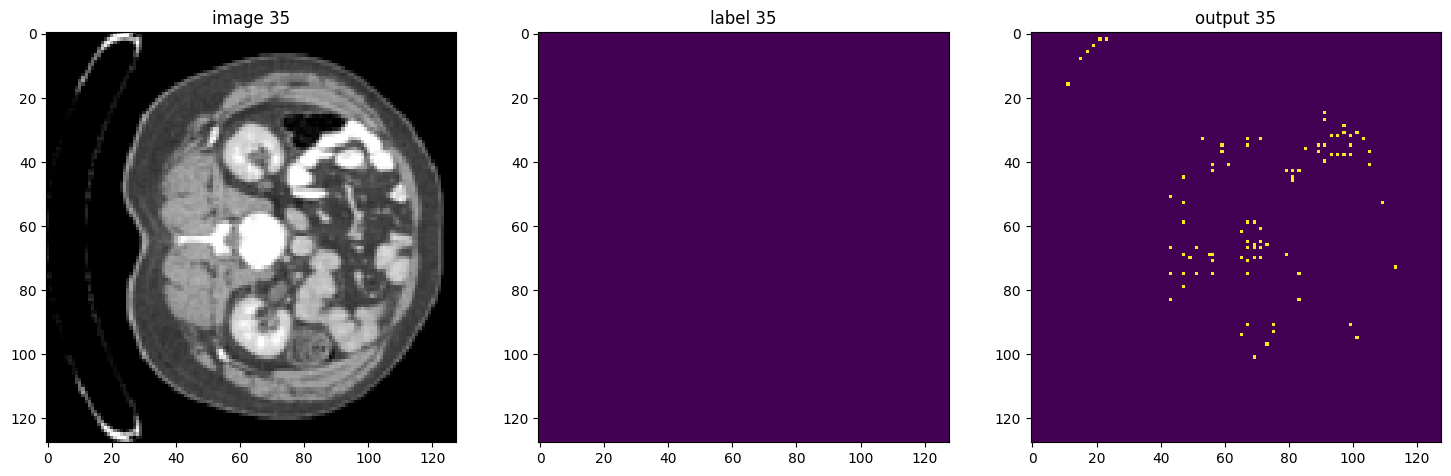

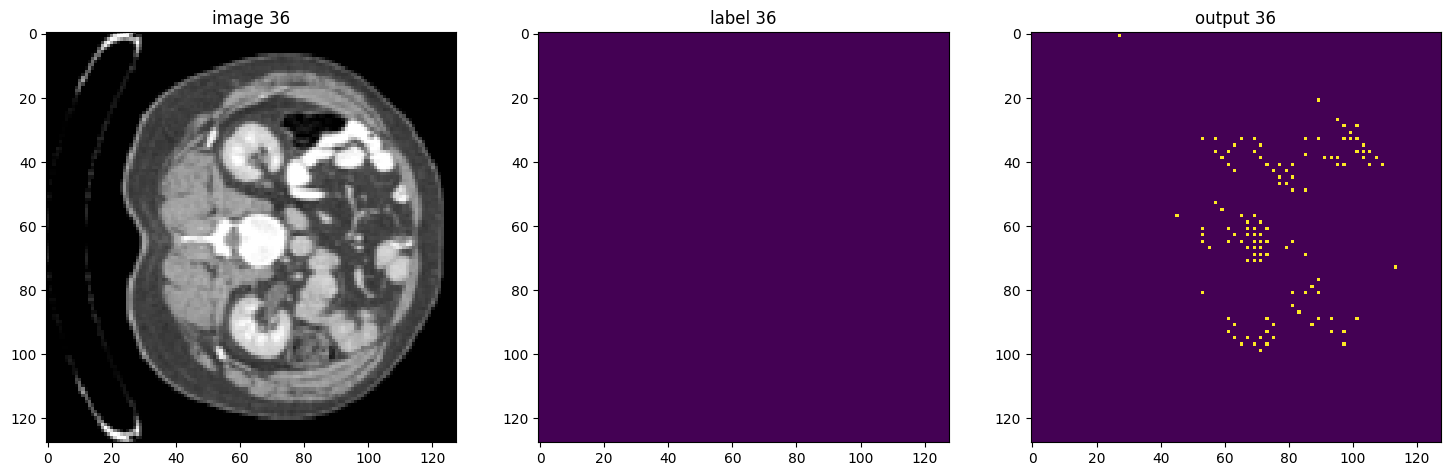

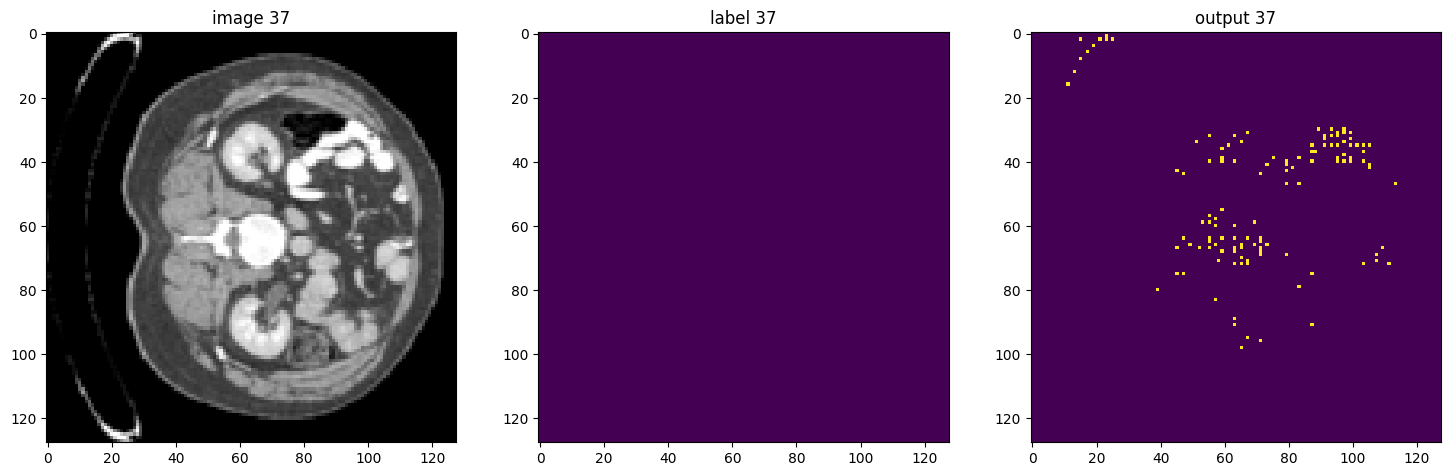

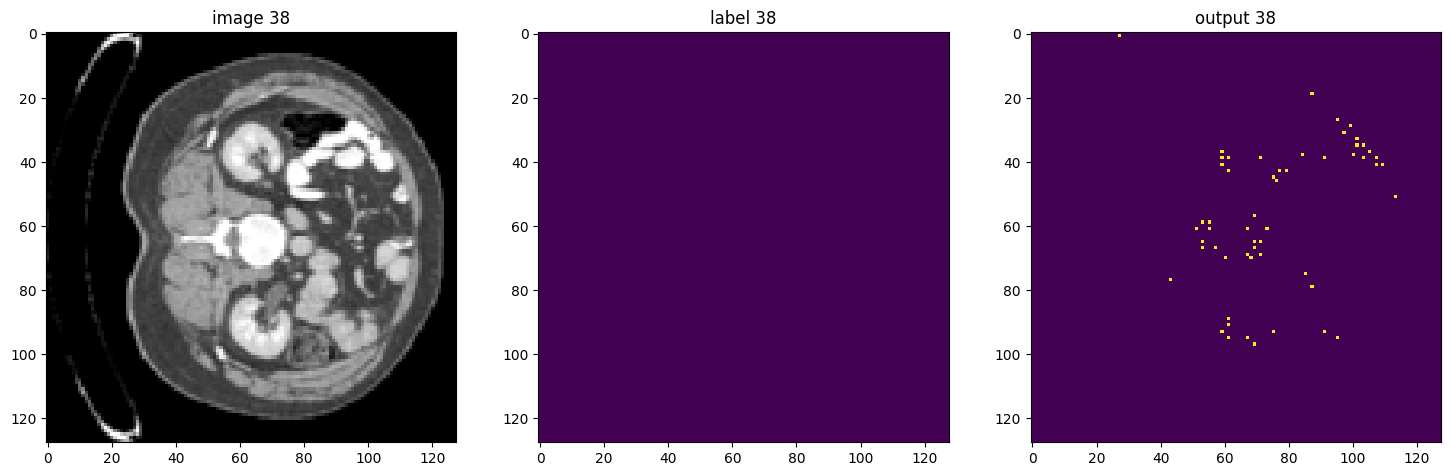

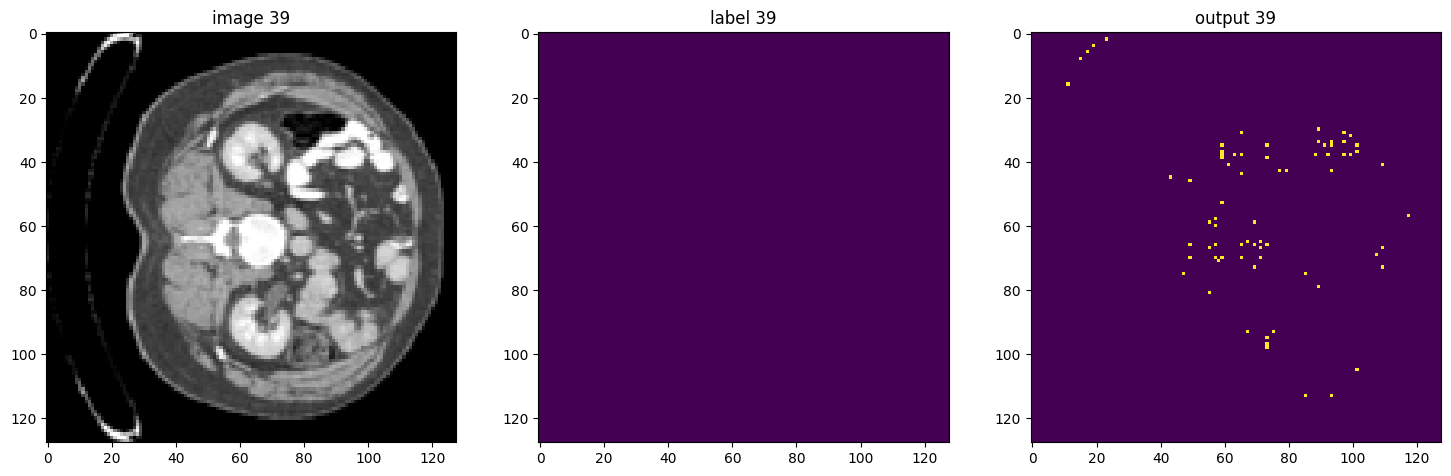

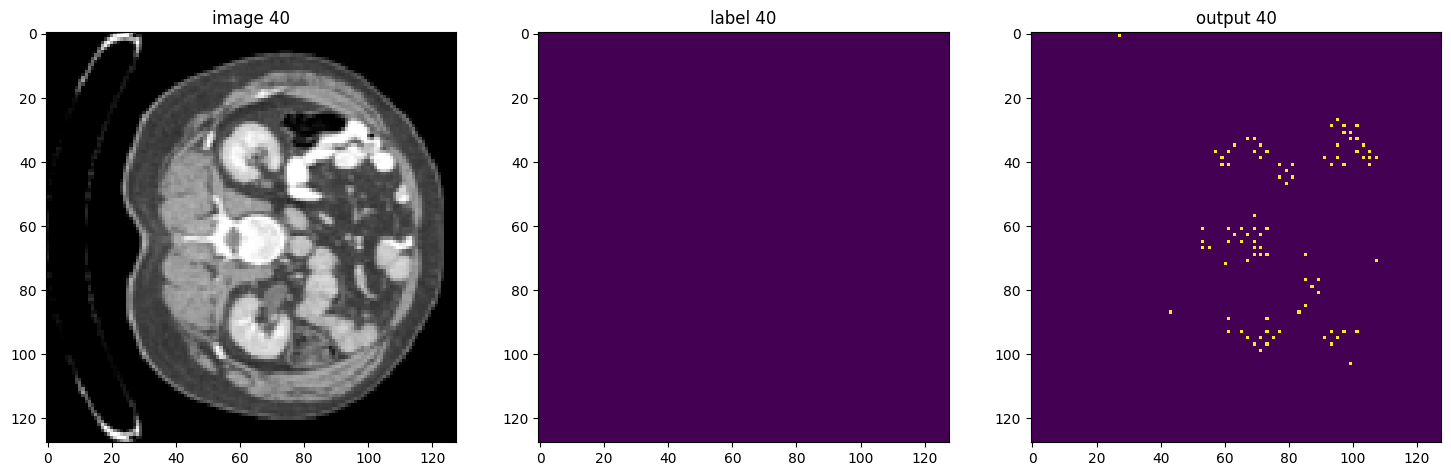

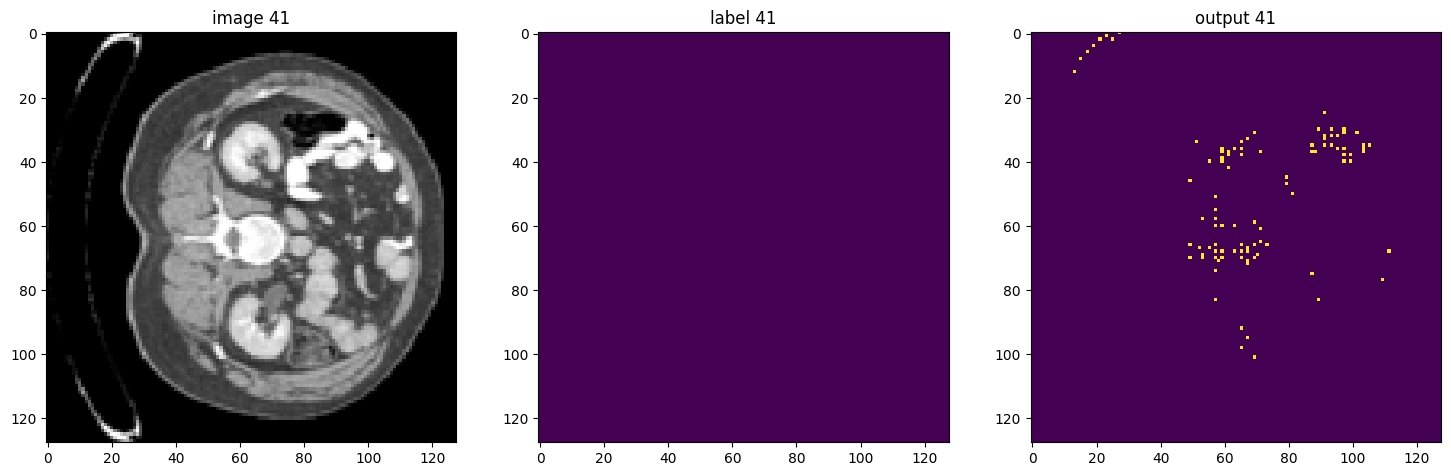

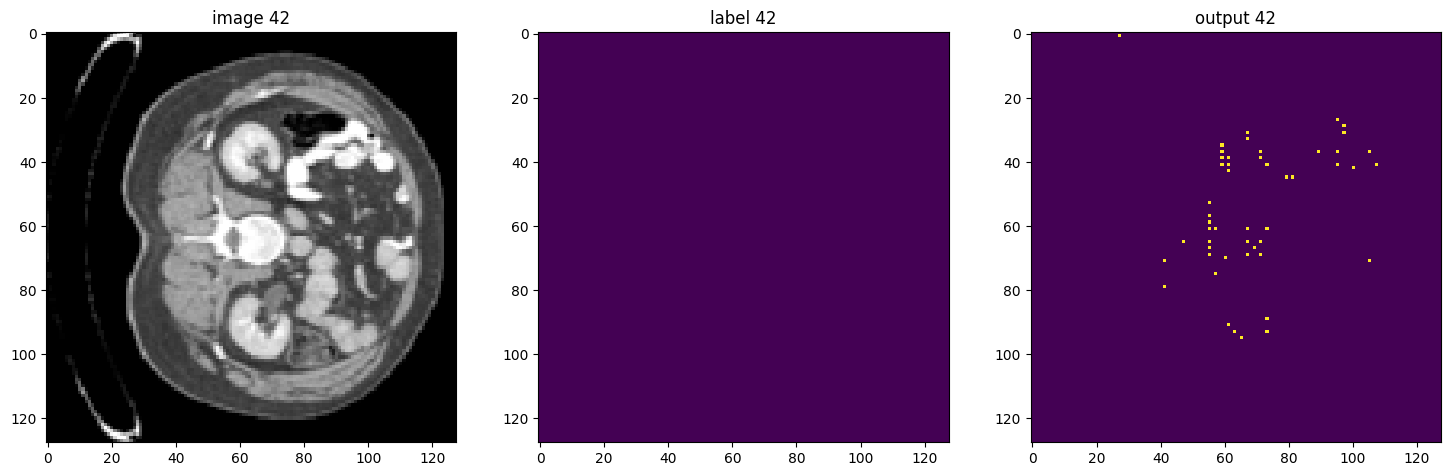

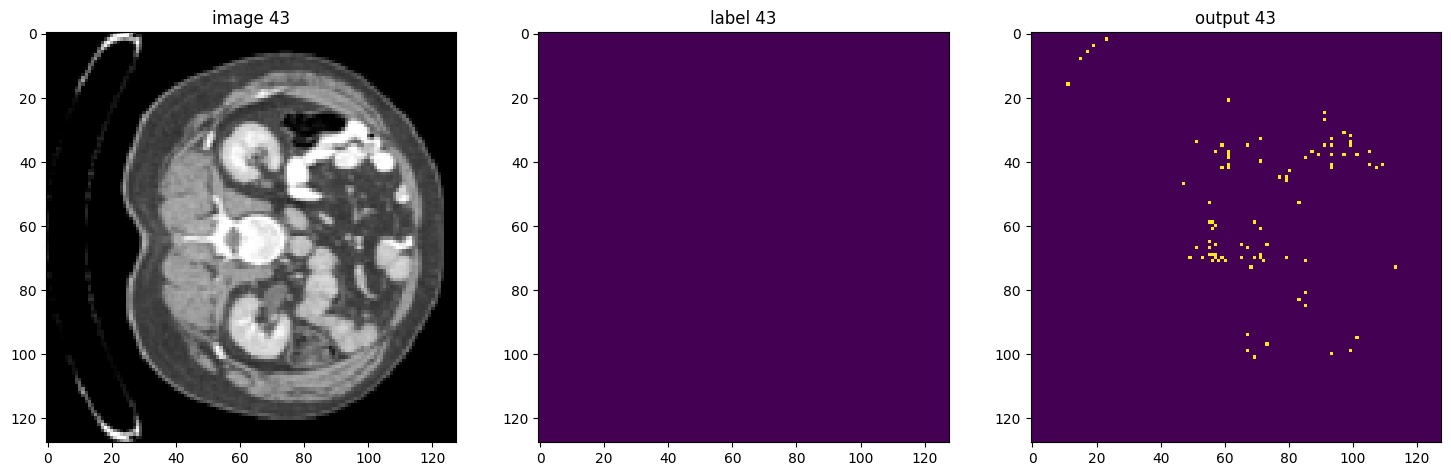

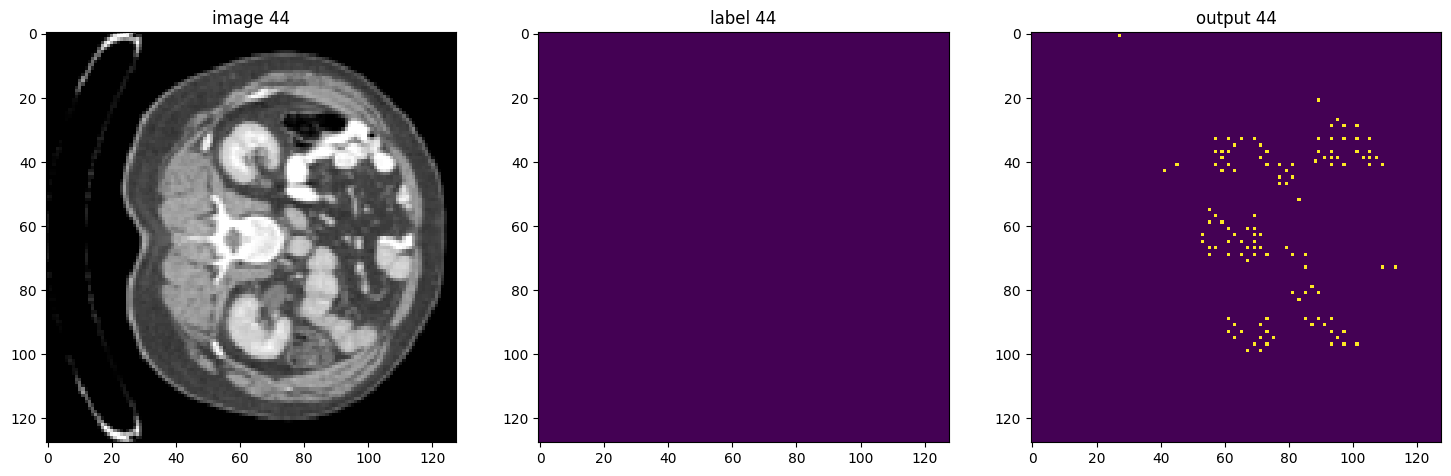

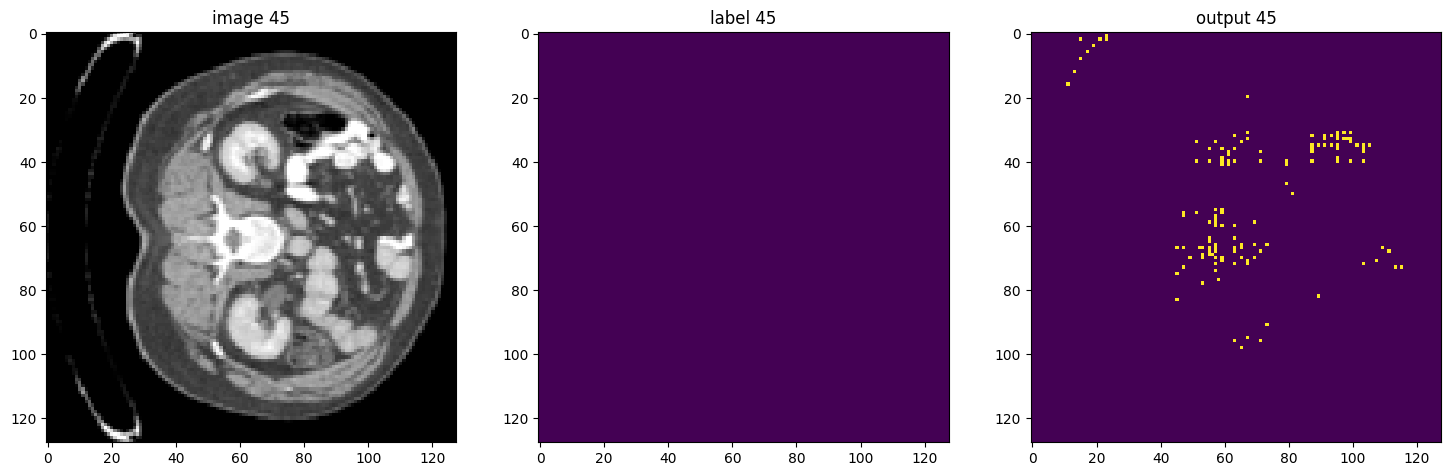

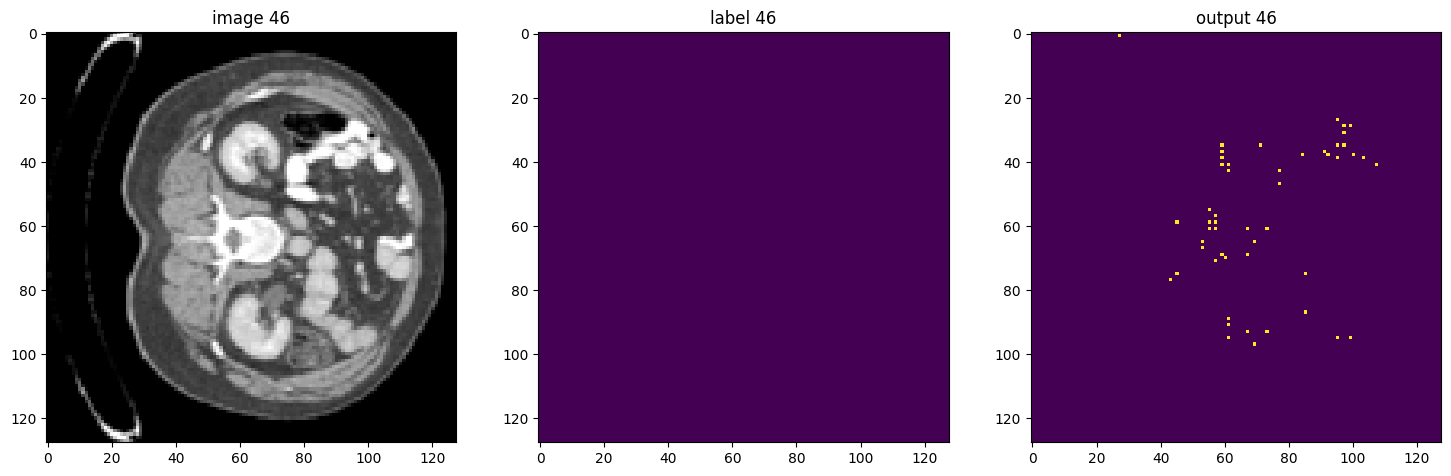

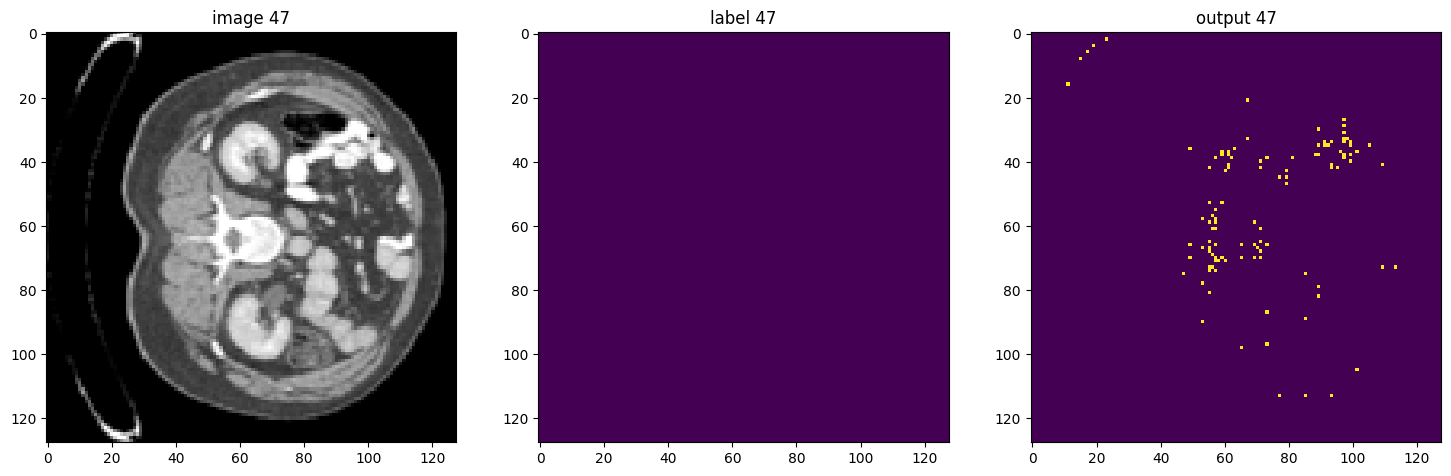

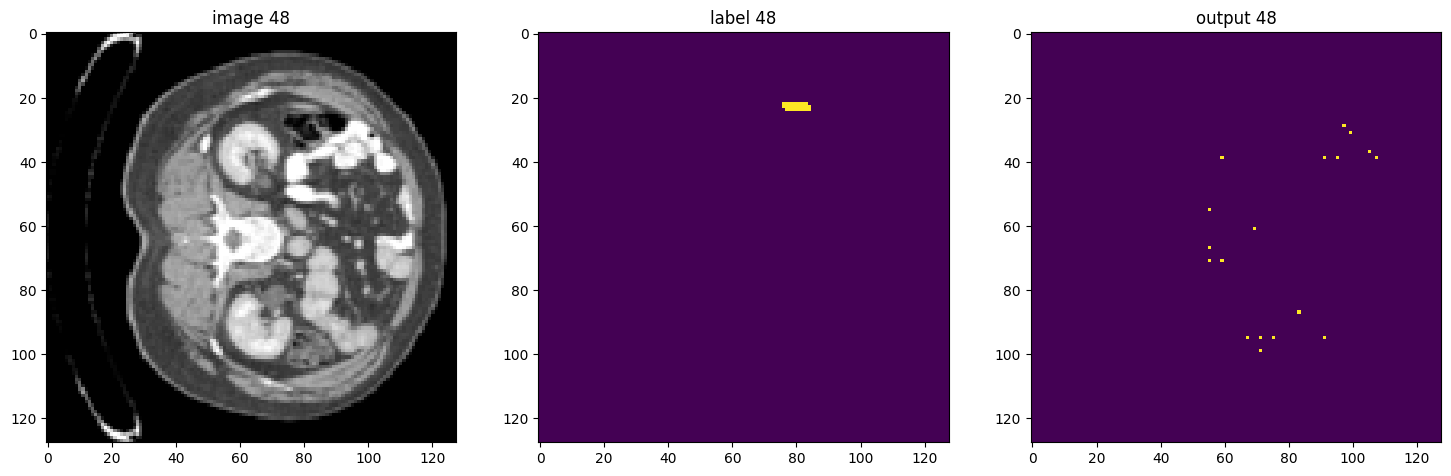

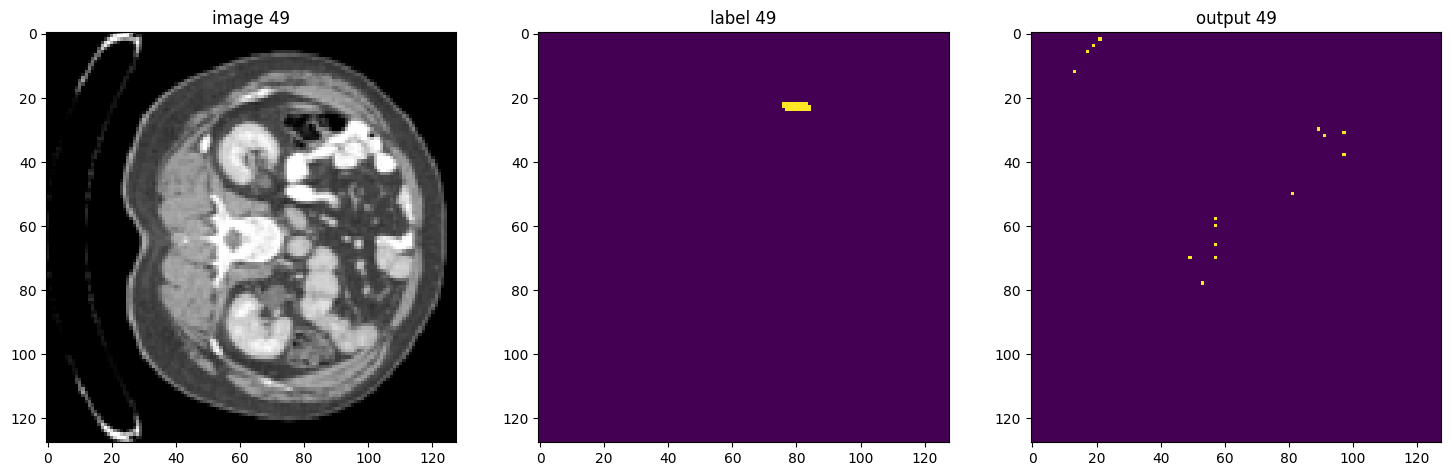

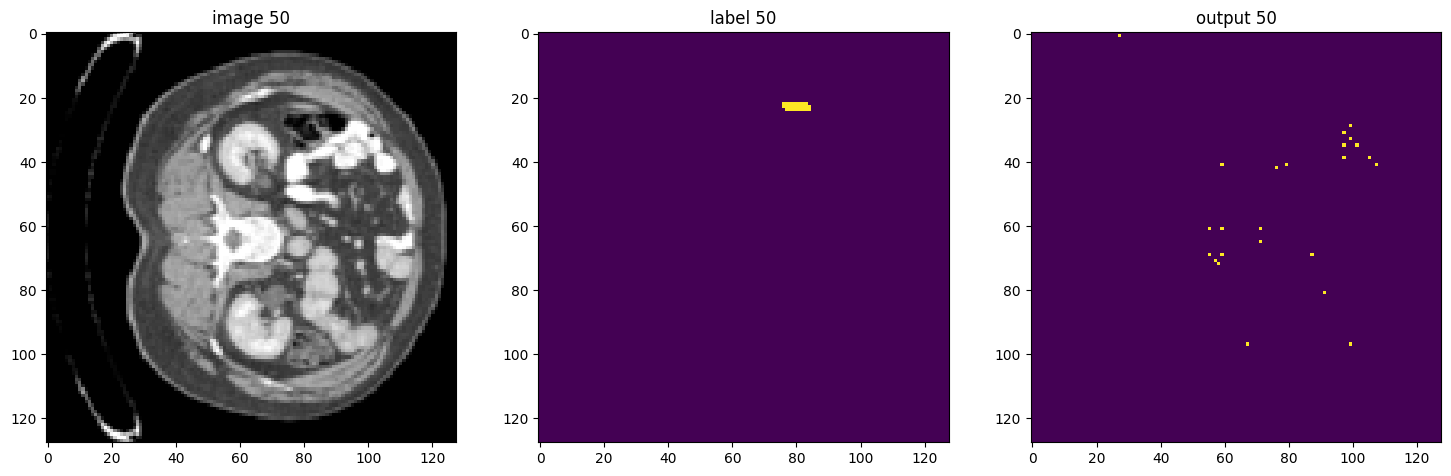

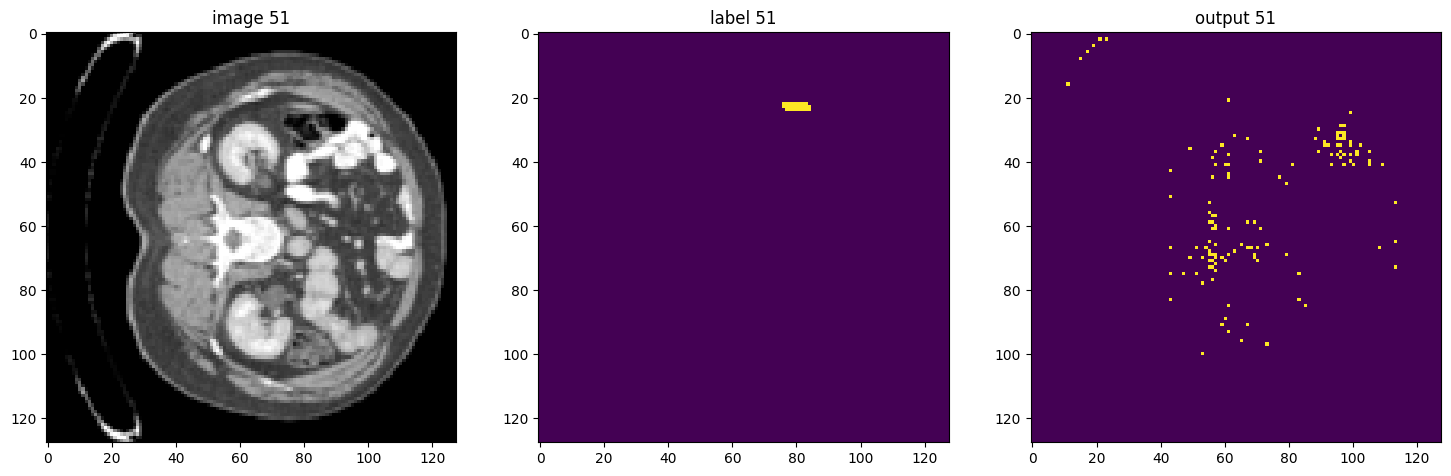

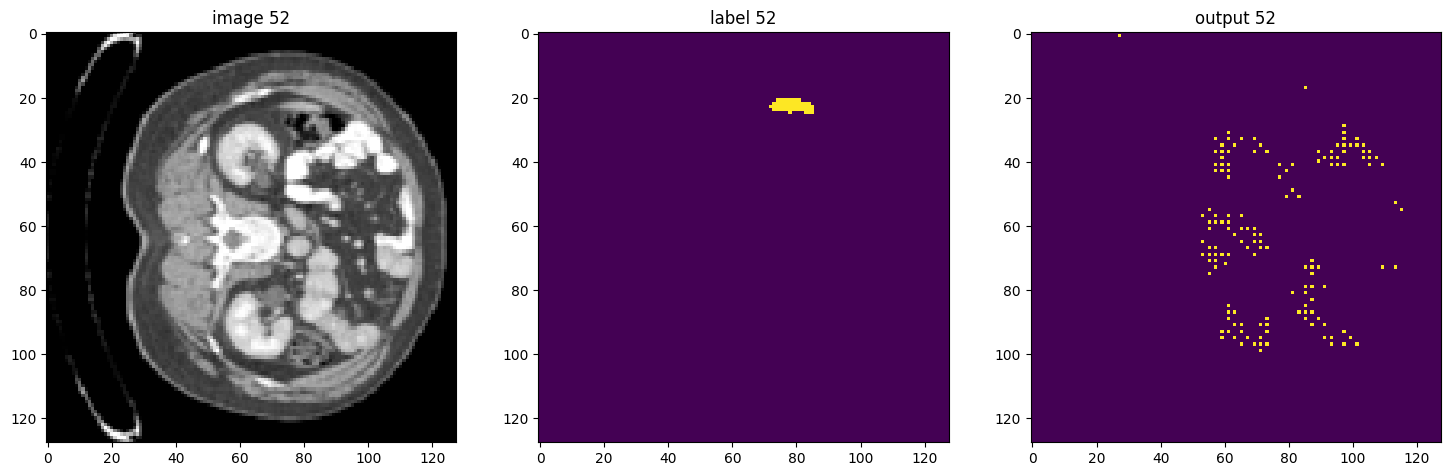

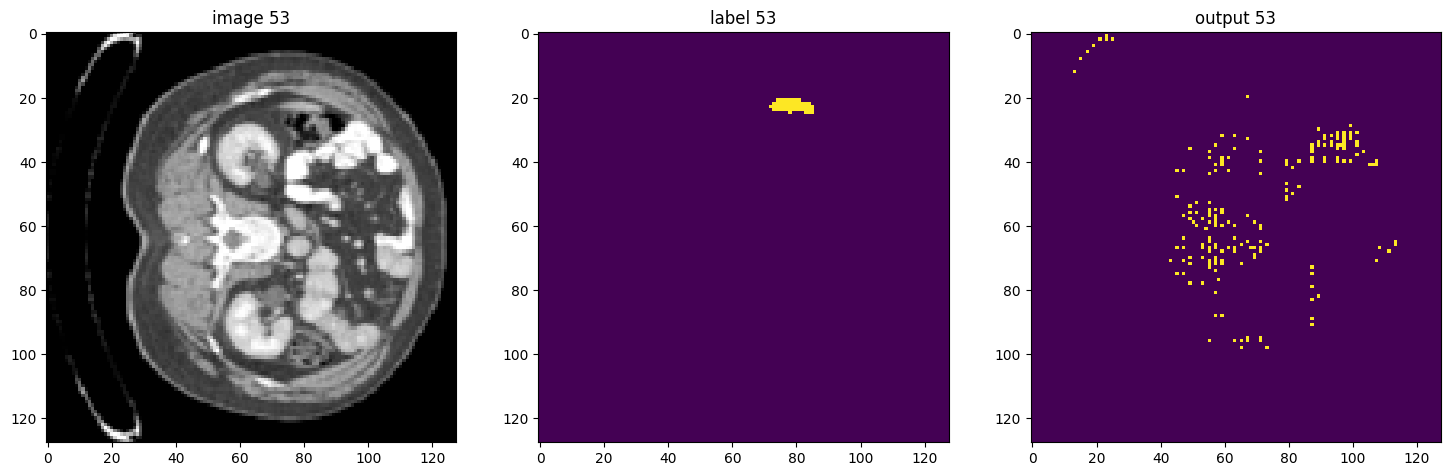

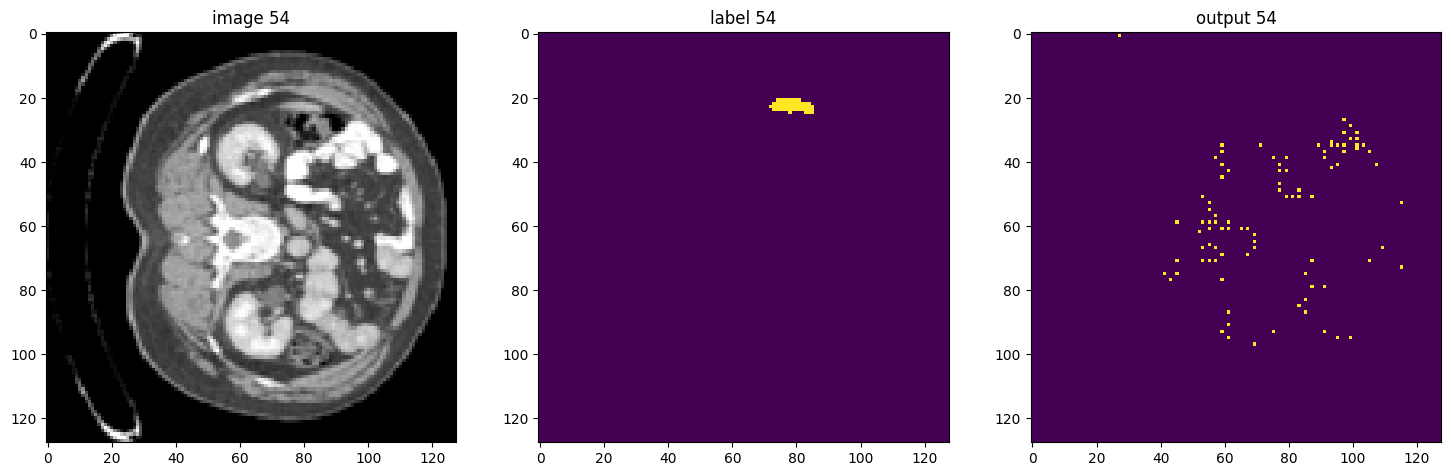

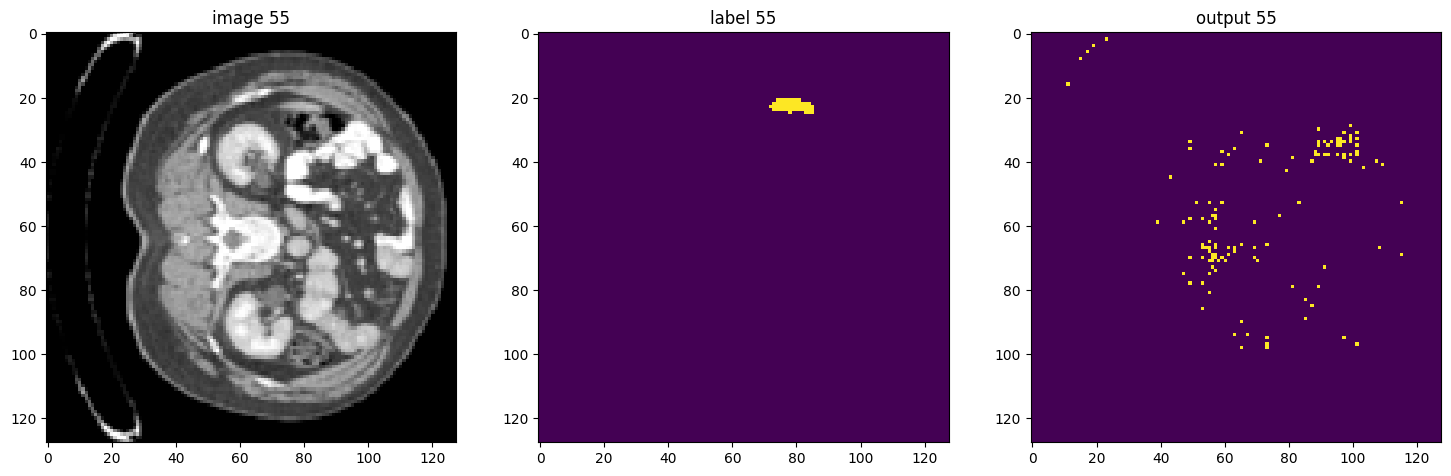

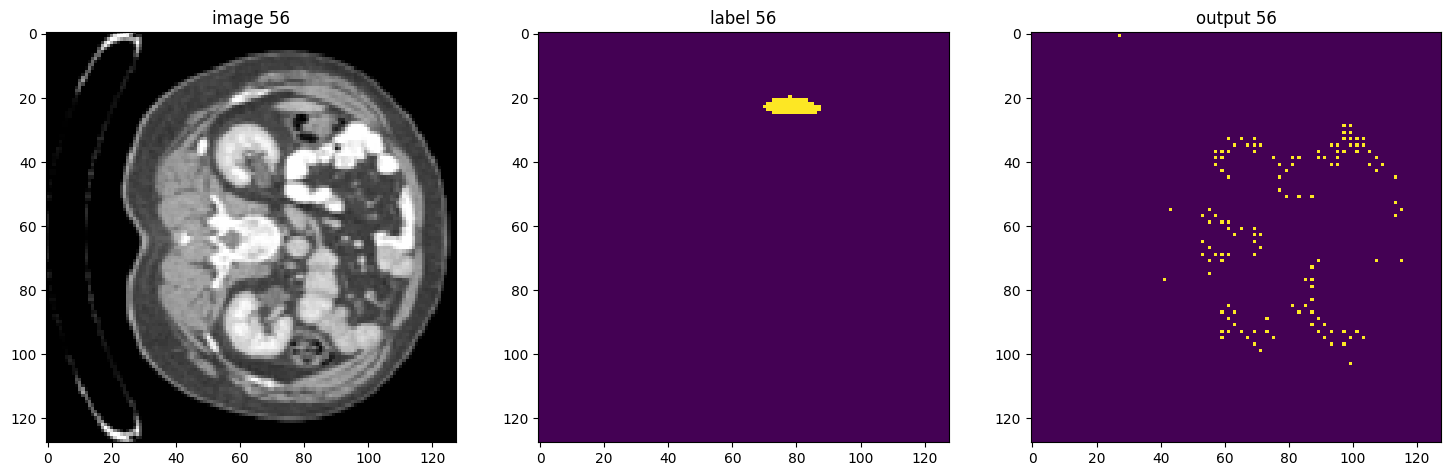

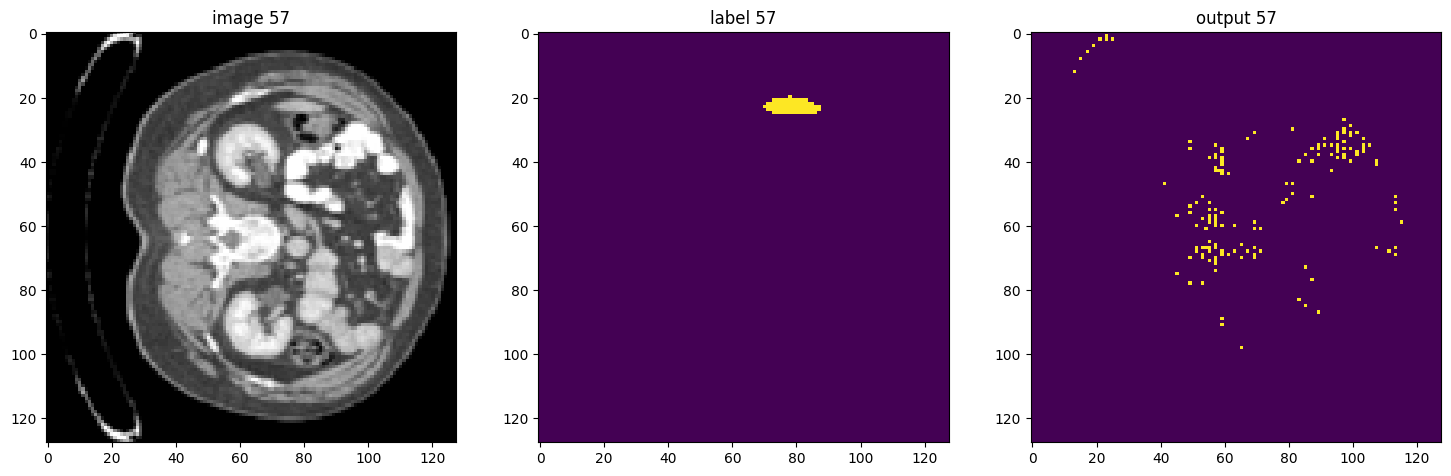

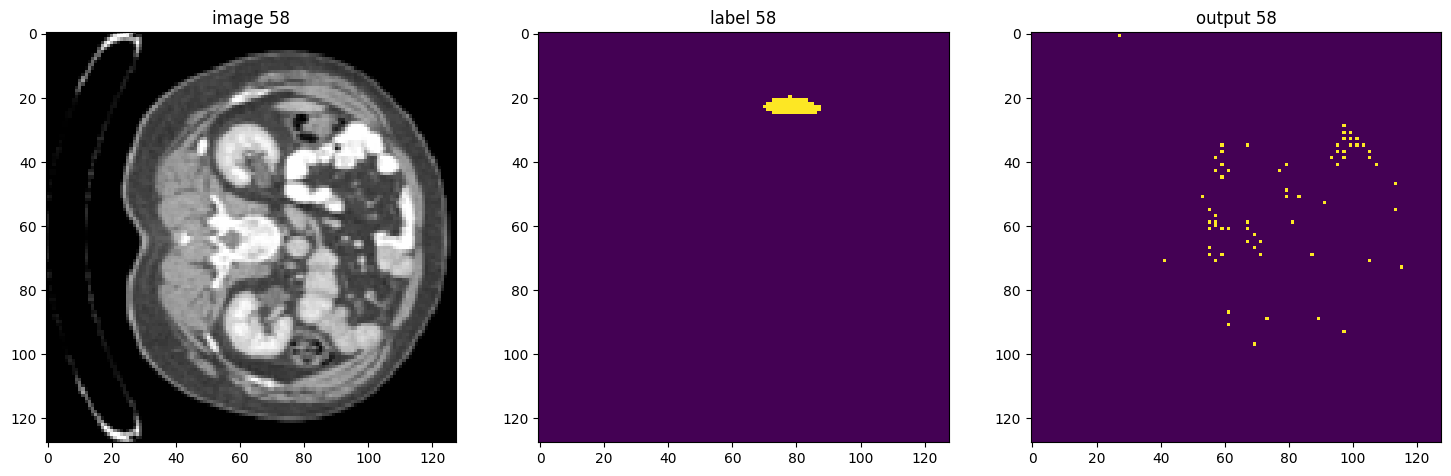

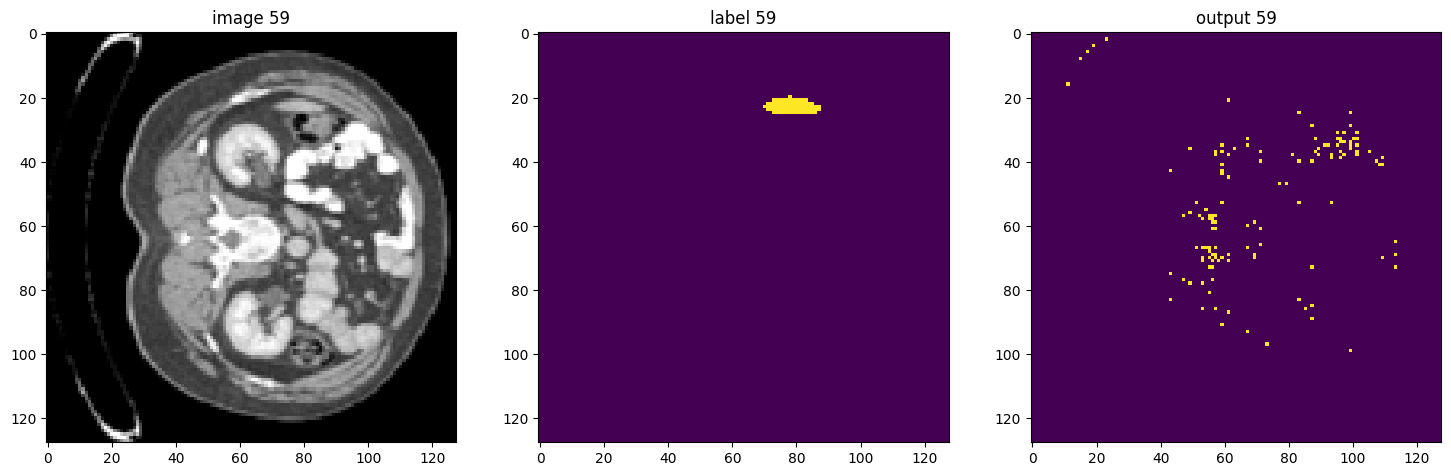

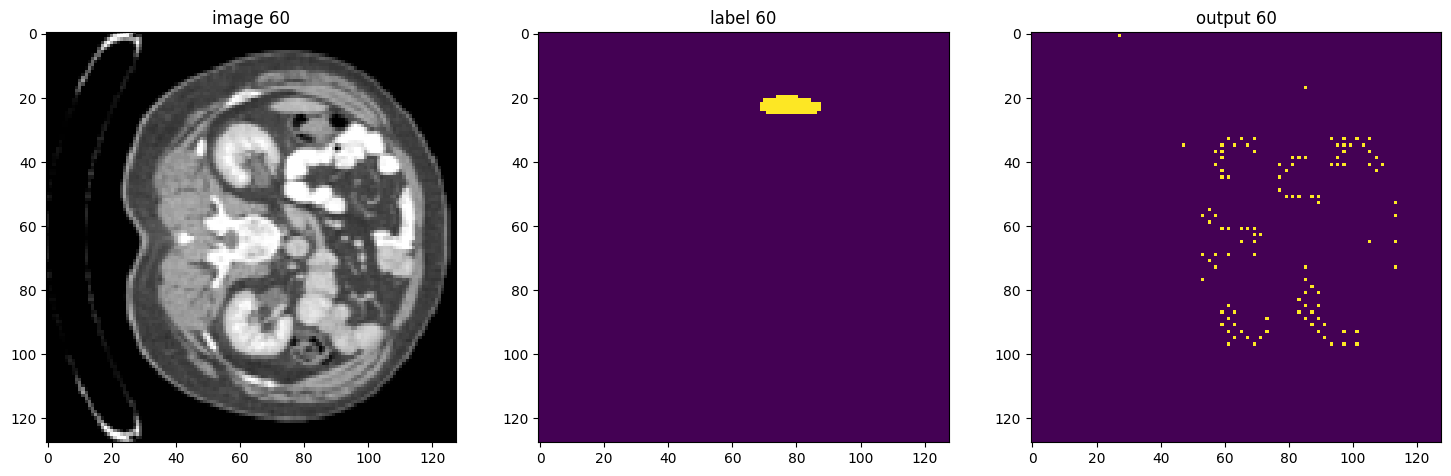

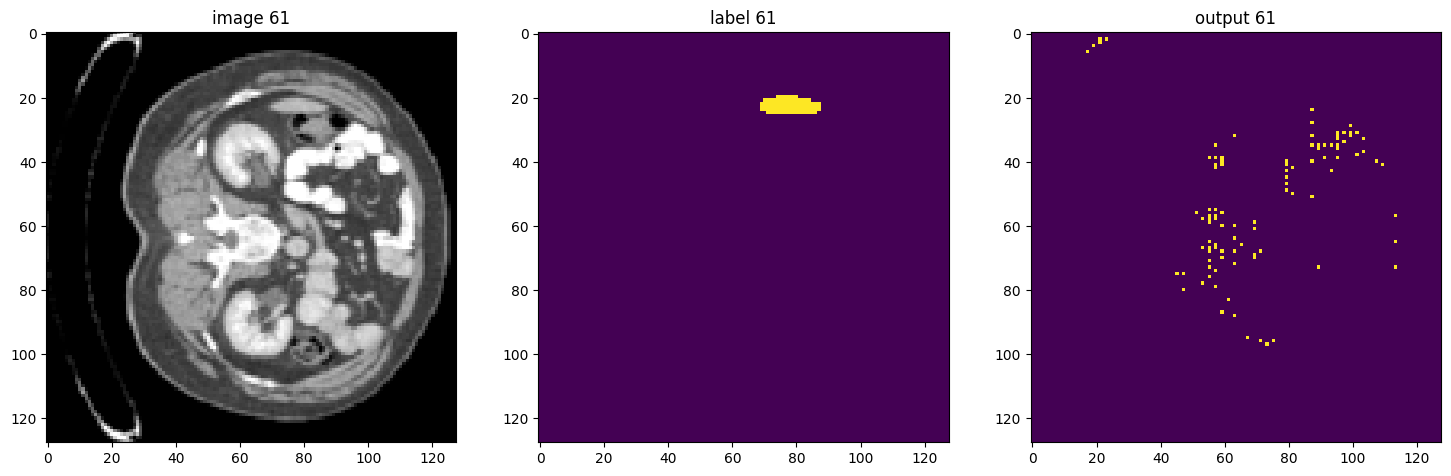

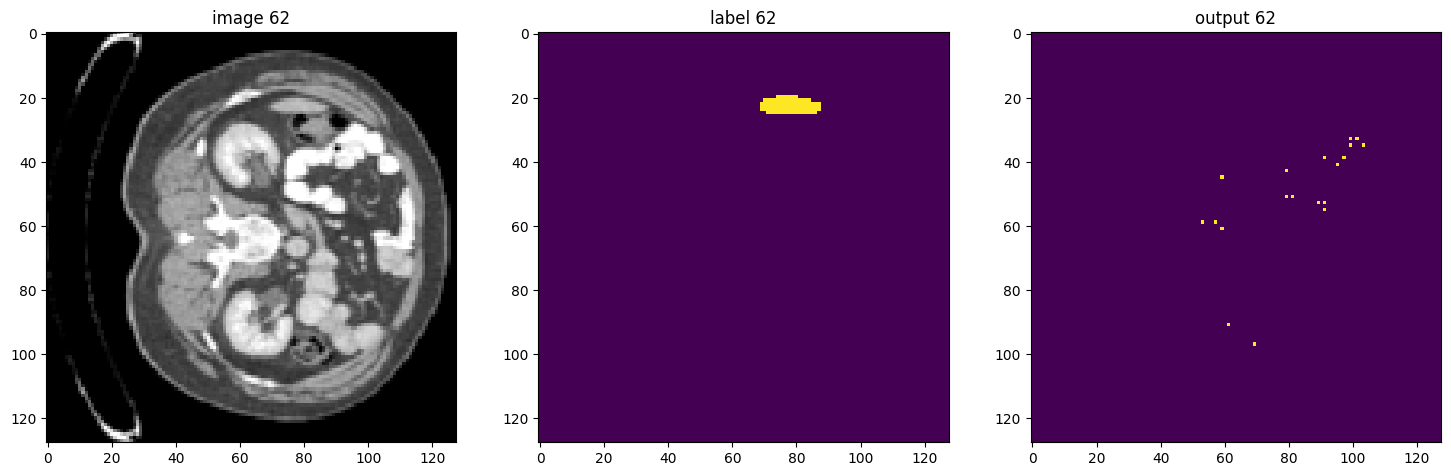

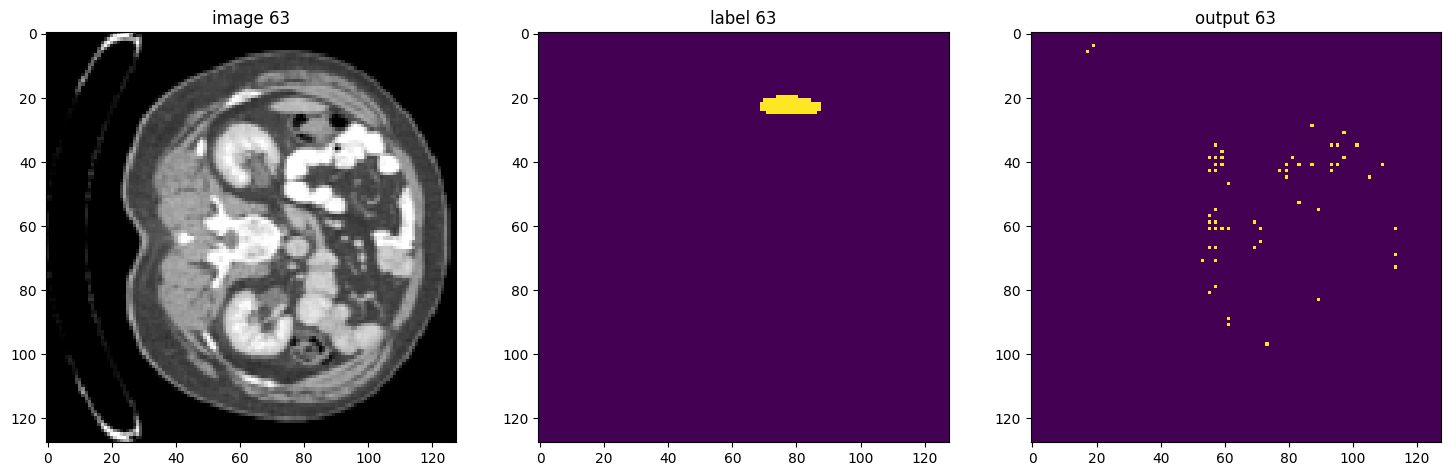

In [18]:
sw_batch_size = 4
roi_size = (64, 64, 64) # (depth, height, width)

with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['image']
    #t_segmentation = test_patient['label']

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.9 # Into binary 0 or 1

    # Inference on 64 slices of image
    for i in range(64):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6)) # Siz eof figure 18x6

        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["image"][0, 0, :, :, i], cmap="gray")

        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["label"][0, 0, :, :, i] != 0)

        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])

        plt.show()

# Sliding Window Inference

The sliding_window_inference function is a common technique used in medical image analysis, particularly in the context of deep learning-based image segmentation. It is used to perform inference (i.e., make predictions) on a large medical image volume by dividing it into smaller overlapping regions or windows, processing these regions separately, and then combining the results to produce a final prediction for the entire volume. This approach is used to handle large images efficiently and to ensure that important details are not missed.

In [19]:
sw_batch_size = 4
roi_size = (64, 64, 64) # (depth, height, width)

with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['image']
    #t_segmentation = test_patient['label']

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)

test_outputs

metatensor([[[[[-1.5292e-01,  1.0187e-01, -5.3702e-02,  ...,  3.7485e-02,
            -7.2720e-02, -1.8568e-01],
           [ 2.3943e-01,  4.9028e-01,  2.2721e-01,  ...,  6.2999e-02,
             2.2745e-01,  4.7793e-03],
           [ 1.8560e-02, -5.8701e-02, -6.3021e-02,  ...,  1.2651e-01,
            -7.8601e-02, -6.4400e-02],
           ...,
           [ 1.7263e-01,  1.1054e+00,  3.5335e-01,  ...,  6.7532e-01,
             2.0389e-01,  3.9411e-01],
           [ 4.8315e-02, -3.8837e-02,  7.7873e-05,  ..., -6.3077e-03,
            -1.8367e-01, -6.8693e-02],
           [ 8.3885e-02,  7.6376e-01,  2.1969e-01,  ...,  8.4605e-01,
             6.7625e-02,  2.0308e-01]],

          [[ 9.3869e-01,  1.3294e+00,  6.2320e-01,  ...,  1.4936e+00,
             1.8965e-01,  2.0638e-01],
           [ 5.6670e-01, -1.6123e-01,  8.5726e-01,  ..., -2.9411e-01,
            -1.7549e-01, -3.9188e-03],
           [ 9.8472e-01,  7.7220e-01,  5.4417e-01,  ...,  4.7842e-01,
            -2.3003e-03,  2.2470e-01

Input Parameters:

**input_volume**: This is the large input image volume on which you want to perform inference. It's typically a 3D medical image, such as a CT scan or an MRI.

**roi_size**: The roi_size parameter specifies the size of the smaller regions or regions of interest (ROIs) into which the input volume is divided. It is usually a tuple (depth, height, width) that defines the 3D size of each ROI. The ROIs are often smaller than the entire volume to manage memory efficiently.

**batch_size**: This parameter indicates the number of ROIs that are processed together in each batch during inference. A larger batch size can lead to better computational efficiency but requires more memory.

**model**: The deep learning model that will be used for inference. This model should be designed for the specific segmentation task you are working on, and it should be capable of processing 3D data.

In [20]:
sigmoid_activation = Activations(sigmoid=True)
test_outputs = sigmoid_activation(test_outputs)

test_outputs

metatensor([[[[[0.4618, 0.5254, 0.4866,  ..., 0.5094, 0.4818, 0.4537],
           [0.5596, 0.6202, 0.5566,  ..., 0.5157, 0.5566, 0.5012],
           [0.5046, 0.4853, 0.4842,  ..., 0.5316, 0.4804, 0.4839],
           ...,
           [0.5431, 0.7513, 0.5874,  ..., 0.6627, 0.5508, 0.5973],
           [0.5121, 0.4903, 0.5000,  ..., 0.4984, 0.4542, 0.4828],
           [0.5210, 0.6822, 0.5547,  ..., 0.6997, 0.5169, 0.5506]],

          [[0.7188, 0.7907, 0.6509,  ..., 0.8166, 0.5473, 0.5514],
           [0.6380, 0.4598, 0.7021,  ..., 0.4270, 0.4562, 0.4990],
           [0.7280, 0.6840, 0.6328,  ..., 0.6174, 0.4994, 0.5559],
           ...,
           [0.4978, 0.5343, 0.5797,  ..., 0.4685, 0.4595, 0.5211],
           [0.5393, 0.5645, 0.4756,  ..., 0.5930, 0.5121, 0.6126],
           [0.4771, 0.4701, 0.4749,  ..., 0.4736, 0.4440, 0.4871]],

          [[0.5029, 0.5769, 0.4698,  ..., 0.5635, 0.4149, 0.5191],
           [0.4278, 0.6110, 0.6349,  ..., 0.6256, 0.5736, 0.6156],
           [0.4928, 0.

It applies the sigmoid activation to the test_outputs. This is commonly used for binary classification tasks to squash the output values between 0 and 1.

In [22]:
test_outputs = test_outputs > 0.53 # Into binary 0 or 1
test_outputs

metatensor([[[[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False]],

          [[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False]],

          [[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, Fal

A threshold of 0.53 is applied to the test_outputs. This is likely used for post-processing to convert the output into binary predictions.